In [311]:
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import *
import random
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [333]:
train = pd.read_csv('../../raw/LiChuan/trainallfeatures.csv')
# test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [334]:
traincopy = train.copy()
train.shape

(9940, 186)

In [335]:
# 去掉 2012 年数据, 噪音太多
train = train[train['year'] > 2012]
train.shape

(8260, 186)

In [315]:
#traintmp = train[-280:-140].copy()
#tmp = traintmp[traintmp['how_many_month_has_sell'] < 13]['class_id'].values
#len(tmp)

In [316]:
#trainSaleLessThen12 = train[train['class_id'].isin(tmp)].copy()
#trainSaleMoreThen12 = train.drop(trainSaleLessThen12.index).copy()
#trainSaleMoreThen12.shape,trainSaleLessThen12.shape

In [317]:
_x = -140
traintmp = train.copy()

In [318]:
# year 和 month 进行 one-hot 编码
traintmp.drop_duplicates(inplace=True)
labels = traintmp.sale_quantity[:_x]
train = traintmp.drop(['class_id','sale_quantity', 'sale_date'], axis=1)

# train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train['year'], prefix='year')
month_dummies = pd.get_dummies(train['month'], prefix='month')
train = pd.concat([train, year_dummies], axis=1)
train = pd.concat([train, month_dummies], axis=1)
train = train.drop(['year', 'month'], axis=1)
train.fillna(0.0, inplace=True)

test = train[_x:].reset_index(drop=True)
train = train[:_x].reset_index(drop=True)

In [322]:
train.shape

(8120, 198)

In [323]:
# 获取 2017-10 作为测试集
test_X = train[-280:-140]
test_Y = labels[-280:-140]
test_X.shape

(140, 198)

In [324]:
# 2013-01 至 2017-10 作为训练集
train_X = train[:-280]
train_Y = labels[:-280]
train_X.shape

(7840, 198)

## 调整 XGBoost 参数

In [325]:
# RMSE = 125
rmses = []
trainset = xgb.DMatrix(train_X,label=train_Y)
testset = xgb.DMatrix(test_X)

params = {
'booster': 'gbtree', # 基于树的模型进行计算
'objective': 'reg:linear', # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 5, # 树的最大深度。缺省值为6
'lambda': 10, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
#'seed': 10,
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=4000,evals=watchlist)
predict_test_X = model.predict(testset)
rmsetmp = sp.sqrt(sp.mean((test_Y - predict_test_X) ** 2))

print('This time rmse is: '+ str(rmsetmp))
rmses.append(rmsetmp)

[0]	train-rmse:437.734
[1]	train-rmse:344.974
[2]	train-rmse:281.943
[3]	train-rmse:241.431
[4]	train-rmse:212.987
[5]	train-rmse:190.738
[6]	train-rmse:178.304
[7]	train-rmse:168.383
[8]	train-rmse:160.586
[9]	train-rmse:153.602
[10]	train-rmse:147.472
[11]	train-rmse:142.956
[12]	train-rmse:139.952
[13]	train-rmse:136.731
[14]	train-rmse:133.504
[15]	train-rmse:131.19
[16]	train-rmse:129.108
[17]	train-rmse:124.078
[18]	train-rmse:123.075
[19]	train-rmse:120.292
[20]	train-rmse:118.308
[21]	train-rmse:115.045
[22]	train-rmse:113.496
[23]	train-rmse:111.924
[24]	train-rmse:110.658
[25]	train-rmse:109.761
[26]	train-rmse:108.026
[27]	train-rmse:106.886
[28]	train-rmse:105.522
[29]	train-rmse:104.547
[30]	train-rmse:102.74
[31]	train-rmse:101.477
[32]	train-rmse:99.5441
[33]	train-rmse:98.1849
[34]	train-rmse:97.0726
[35]	train-rmse:96.2812
[36]	train-rmse:95.0004
[37]	train-rmse:94.2117
[38]	train-rmse:93.7034
[39]	train-rmse:93.2289
[40]	train-rmse:92.0263
[41]	train-rmse:91.6103
[42]

[334]	train-rmse:19.6421
[335]	train-rmse:19.5627
[336]	train-rmse:19.4915
[337]	train-rmse:19.4361
[338]	train-rmse:19.4009
[339]	train-rmse:19.3289
[340]	train-rmse:19.2276
[341]	train-rmse:19.1248
[342]	train-rmse:19.0442
[343]	train-rmse:18.96
[344]	train-rmse:18.929
[345]	train-rmse:18.8681
[346]	train-rmse:18.7796
[347]	train-rmse:18.7211
[348]	train-rmse:18.6096
[349]	train-rmse:18.5293
[350]	train-rmse:18.4452
[351]	train-rmse:18.357
[352]	train-rmse:18.2883
[353]	train-rmse:18.2351
[354]	train-rmse:18.1818
[355]	train-rmse:18.0881
[356]	train-rmse:18.0416
[357]	train-rmse:17.9604
[358]	train-rmse:17.8879
[359]	train-rmse:17.8272
[360]	train-rmse:17.7676
[361]	train-rmse:17.7183
[362]	train-rmse:17.6277
[363]	train-rmse:17.5781
[364]	train-rmse:17.5054
[365]	train-rmse:17.4534
[366]	train-rmse:17.3791
[367]	train-rmse:17.3235
[368]	train-rmse:17.2628
[369]	train-rmse:17.2084
[370]	train-rmse:17.1726
[371]	train-rmse:17.1083
[372]	train-rmse:17.0394
[373]	train-rmse:16.958
[374]

[663]	train-rmse:6.60404
[664]	train-rmse:6.58696
[665]	train-rmse:6.56529
[666]	train-rmse:6.54938
[667]	train-rmse:6.53121
[668]	train-rmse:6.52515
[669]	train-rmse:6.5136
[670]	train-rmse:6.50499
[671]	train-rmse:6.48437
[672]	train-rmse:6.45444
[673]	train-rmse:6.43834
[674]	train-rmse:6.42328
[675]	train-rmse:6.39718
[676]	train-rmse:6.38369
[677]	train-rmse:6.33073
[678]	train-rmse:6.31058
[679]	train-rmse:6.28835
[680]	train-rmse:6.27735
[681]	train-rmse:6.26705
[682]	train-rmse:6.2486
[683]	train-rmse:6.23657
[684]	train-rmse:6.22274
[685]	train-rmse:6.20849
[686]	train-rmse:6.19146
[687]	train-rmse:6.17882
[688]	train-rmse:6.16705
[689]	train-rmse:6.14814
[690]	train-rmse:6.11673
[691]	train-rmse:6.09886
[692]	train-rmse:6.09054
[693]	train-rmse:6.08308
[694]	train-rmse:6.05704
[695]	train-rmse:6.02387
[696]	train-rmse:6.01508
[697]	train-rmse:5.98987
[698]	train-rmse:5.97707
[699]	train-rmse:5.96145
[700]	train-rmse:5.95399
[701]	train-rmse:5.94416
[702]	train-rmse:5.92618
[7

[992]	train-rmse:2.89288
[993]	train-rmse:2.88365
[994]	train-rmse:2.88001
[995]	train-rmse:2.87529
[996]	train-rmse:2.86703
[997]	train-rmse:2.85822
[998]	train-rmse:2.85142
[999]	train-rmse:2.84505
[1000]	train-rmse:2.83424
[1001]	train-rmse:2.82766
[1002]	train-rmse:2.81993
[1003]	train-rmse:2.81086
[1004]	train-rmse:2.80531
[1005]	train-rmse:2.80014
[1006]	train-rmse:2.7914
[1007]	train-rmse:2.78583
[1008]	train-rmse:2.78198
[1009]	train-rmse:2.77569
[1010]	train-rmse:2.77136
[1011]	train-rmse:2.76701
[1012]	train-rmse:2.7635
[1013]	train-rmse:2.75834
[1014]	train-rmse:2.75197
[1015]	train-rmse:2.74199
[1016]	train-rmse:2.73324
[1017]	train-rmse:2.73001
[1018]	train-rmse:2.72527
[1019]	train-rmse:2.7183
[1020]	train-rmse:2.71145
[1021]	train-rmse:2.70821
[1022]	train-rmse:2.70405
[1023]	train-rmse:2.69759
[1024]	train-rmse:2.69159
[1025]	train-rmse:2.68505
[1026]	train-rmse:2.67214
[1027]	train-rmse:2.66739
[1028]	train-rmse:2.66251
[1029]	train-rmse:2.65603
[1030]	train-rmse:2.652

[1309]	train-rmse:1.5191
[1310]	train-rmse:1.51773
[1311]	train-rmse:1.51492
[1312]	train-rmse:1.51279
[1313]	train-rmse:1.50948
[1314]	train-rmse:1.50698
[1315]	train-rmse:1.50504
[1316]	train-rmse:1.50215
[1317]	train-rmse:1.49912
[1318]	train-rmse:1.49548
[1319]	train-rmse:1.49341
[1320]	train-rmse:1.49085
[1321]	train-rmse:1.48768
[1322]	train-rmse:1.48433
[1323]	train-rmse:1.48195
[1324]	train-rmse:1.47988
[1325]	train-rmse:1.47442
[1326]	train-rmse:1.47148
[1327]	train-rmse:1.46974
[1328]	train-rmse:1.46753
[1329]	train-rmse:1.46623
[1330]	train-rmse:1.45886
[1331]	train-rmse:1.4574
[1332]	train-rmse:1.45531
[1333]	train-rmse:1.45152
[1334]	train-rmse:1.44976
[1335]	train-rmse:1.44832
[1336]	train-rmse:1.4469
[1337]	train-rmse:1.44515
[1338]	train-rmse:1.44284
[1339]	train-rmse:1.43761
[1340]	train-rmse:1.43516
[1341]	train-rmse:1.43318
[1342]	train-rmse:1.431
[1343]	train-rmse:1.42916
[1344]	train-rmse:1.42763
[1345]	train-rmse:1.42545
[1346]	train-rmse:1.42331
[1347]	train-rmse

[1624]	train-rmse:0.919478
[1625]	train-rmse:0.918112
[1626]	train-rmse:0.9152
[1627]	train-rmse:0.913753
[1628]	train-rmse:0.912909
[1629]	train-rmse:0.911444
[1630]	train-rmse:0.910809
[1631]	train-rmse:0.909481
[1632]	train-rmse:0.908249
[1633]	train-rmse:0.90717
[1634]	train-rmse:0.906014
[1635]	train-rmse:0.904847
[1636]	train-rmse:0.903153
[1637]	train-rmse:0.901475
[1638]	train-rmse:0.900402
[1639]	train-rmse:0.8997
[1640]	train-rmse:0.898618
[1641]	train-rmse:0.897227
[1642]	train-rmse:0.894913
[1643]	train-rmse:0.894304
[1644]	train-rmse:0.892443
[1645]	train-rmse:0.891438
[1646]	train-rmse:0.890114
[1647]	train-rmse:0.889598
[1648]	train-rmse:0.88772
[1649]	train-rmse:0.886425
[1650]	train-rmse:0.885151
[1651]	train-rmse:0.883955
[1652]	train-rmse:0.882685
[1653]	train-rmse:0.881671
[1654]	train-rmse:0.88009
[1655]	train-rmse:0.879744
[1656]	train-rmse:0.878741
[1657]	train-rmse:0.877565
[1658]	train-rmse:0.876277
[1659]	train-rmse:0.874912
[1660]	train-rmse:0.873172
[1661]	t

[1929]	train-rmse:0.609842
[1930]	train-rmse:0.6094
[1931]	train-rmse:0.608461
[1932]	train-rmse:0.607774
[1933]	train-rmse:0.607195
[1934]	train-rmse:0.60652
[1935]	train-rmse:0.606114
[1936]	train-rmse:0.605569
[1937]	train-rmse:0.605032
[1938]	train-rmse:0.604175
[1939]	train-rmse:0.603193
[1940]	train-rmse:0.602633
[1941]	train-rmse:0.602348
[1942]	train-rmse:0.601655
[1943]	train-rmse:0.600897
[1944]	train-rmse:0.600074
[1945]	train-rmse:0.599473
[1946]	train-rmse:0.599196
[1947]	train-rmse:0.598425
[1948]	train-rmse:0.597753
[1949]	train-rmse:0.596469
[1950]	train-rmse:0.595853
[1951]	train-rmse:0.595095
[1952]	train-rmse:0.594747
[1953]	train-rmse:0.59376
[1954]	train-rmse:0.593127
[1955]	train-rmse:0.592334
[1956]	train-rmse:0.591467
[1957]	train-rmse:0.590938
[1958]	train-rmse:0.590077
[1959]	train-rmse:0.589485
[1960]	train-rmse:0.588993
[1961]	train-rmse:0.588489
[1962]	train-rmse:0.587565
[1963]	train-rmse:0.587043
[1964]	train-rmse:0.58639
[1965]	train-rmse:0.585771
[1966]

[2234]	train-rmse:0.432156
[2235]	train-rmse:0.431679
[2236]	train-rmse:0.43107
[2237]	train-rmse:0.430514
[2238]	train-rmse:0.43009
[2239]	train-rmse:0.429989
[2240]	train-rmse:0.429477
[2241]	train-rmse:0.428975
[2242]	train-rmse:0.428585
[2243]	train-rmse:0.428217
[2244]	train-rmse:0.427772
[2245]	train-rmse:0.427325
[2246]	train-rmse:0.426643
[2247]	train-rmse:0.426274
[2248]	train-rmse:0.425713
[2249]	train-rmse:0.425219
[2250]	train-rmse:0.424752
[2251]	train-rmse:0.424282
[2252]	train-rmse:0.423965
[2253]	train-rmse:0.423629
[2254]	train-rmse:0.423064
[2255]	train-rmse:0.422533
[2256]	train-rmse:0.422179
[2257]	train-rmse:0.421806
[2258]	train-rmse:0.421558
[2259]	train-rmse:0.420967
[2260]	train-rmse:0.420484
[2261]	train-rmse:0.420123
[2262]	train-rmse:0.419616
[2263]	train-rmse:0.419184
[2264]	train-rmse:0.418634
[2265]	train-rmse:0.417743
[2266]	train-rmse:0.417408
[2267]	train-rmse:0.417112
[2268]	train-rmse:0.416773
[2269]	train-rmse:0.416261
[2270]	train-rmse:0.415247
[22

[2539]	train-rmse:0.321645
[2540]	train-rmse:0.321375
[2541]	train-rmse:0.32082
[2542]	train-rmse:0.320711
[2543]	train-rmse:0.320479
[2544]	train-rmse:0.320399
[2545]	train-rmse:0.320251
[2546]	train-rmse:0.320031
[2547]	train-rmse:0.319709
[2548]	train-rmse:0.31944
[2549]	train-rmse:0.319106
[2550]	train-rmse:0.318863
[2551]	train-rmse:0.318559
[2552]	train-rmse:0.318381
[2553]	train-rmse:0.318206
[2554]	train-rmse:0.317997
[2555]	train-rmse:0.317855
[2556]	train-rmse:0.317654
[2557]	train-rmse:0.317556
[2558]	train-rmse:0.317172
[2559]	train-rmse:0.316991
[2560]	train-rmse:0.316535
[2561]	train-rmse:0.316353
[2562]	train-rmse:0.316173
[2563]	train-rmse:0.315831
[2564]	train-rmse:0.31544
[2565]	train-rmse:0.315277
[2566]	train-rmse:0.315022
[2567]	train-rmse:0.314774
[2568]	train-rmse:0.314488
[2569]	train-rmse:0.314293
[2570]	train-rmse:0.314003
[2571]	train-rmse:0.3139
[2572]	train-rmse:0.313805
[2573]	train-rmse:0.313578
[2574]	train-rmse:0.313217
[2575]	train-rmse:0.313059
[2576]

[2844]	train-rmse:0.259315
[2845]	train-rmse:0.259185
[2846]	train-rmse:0.258885
[2847]	train-rmse:0.258698
[2848]	train-rmse:0.258593
[2849]	train-rmse:0.258432
[2850]	train-rmse:0.258314
[2851]	train-rmse:0.25818
[2852]	train-rmse:0.258039
[2853]	train-rmse:0.257844
[2854]	train-rmse:0.257807
[2855]	train-rmse:0.257702
[2856]	train-rmse:0.257641
[2857]	train-rmse:0.25752
[2858]	train-rmse:0.257335
[2859]	train-rmse:0.257256
[2860]	train-rmse:0.257095
[2861]	train-rmse:0.256968
[2862]	train-rmse:0.256804
[2863]	train-rmse:0.256703
[2864]	train-rmse:0.256494
[2865]	train-rmse:0.256405
[2866]	train-rmse:0.256326
[2867]	train-rmse:0.256032
[2868]	train-rmse:0.255846
[2869]	train-rmse:0.255748
[2870]	train-rmse:0.255583
[2871]	train-rmse:0.255435
[2872]	train-rmse:0.255168
[2873]	train-rmse:0.255077
[2874]	train-rmse:0.254965
[2875]	train-rmse:0.25477
[2876]	train-rmse:0.254613
[2877]	train-rmse:0.25449
[2878]	train-rmse:0.254434
[2879]	train-rmse:0.254319
[2880]	train-rmse:0.254302
[2881

[3150]	train-rmse:0.223311
[3151]	train-rmse:0.223227
[3152]	train-rmse:0.223105
[3153]	train-rmse:0.223025
[3154]	train-rmse:0.222872
[3155]	train-rmse:0.222773
[3156]	train-rmse:0.222755
[3157]	train-rmse:0.222566
[3158]	train-rmse:0.222557
[3159]	train-rmse:0.222514
[3160]	train-rmse:0.222413
[3161]	train-rmse:0.222259
[3162]	train-rmse:0.222186
[3163]	train-rmse:0.221986
[3164]	train-rmse:0.221901
[3165]	train-rmse:0.221738
[3166]	train-rmse:0.221718
[3167]	train-rmse:0.221613
[3168]	train-rmse:0.221359
[3169]	train-rmse:0.221163
[3170]	train-rmse:0.221033
[3171]	train-rmse:0.220967
[3172]	train-rmse:0.220889
[3173]	train-rmse:0.220858
[3174]	train-rmse:0.220832
[3175]	train-rmse:0.220764
[3176]	train-rmse:0.220521
[3177]	train-rmse:0.220474
[3178]	train-rmse:0.220408
[3179]	train-rmse:0.220296
[3180]	train-rmse:0.220165
[3181]	train-rmse:0.220016
[3182]	train-rmse:0.219879
[3183]	train-rmse:0.219702
[3184]	train-rmse:0.219558
[3185]	train-rmse:0.219475
[3186]	train-rmse:0.219301
[

[3455]	train-rmse:0.19861
[3456]	train-rmse:0.198596
[3457]	train-rmse:0.198573
[3458]	train-rmse:0.198523
[3459]	train-rmse:0.198466
[3460]	train-rmse:0.198318
[3461]	train-rmse:0.198255
[3462]	train-rmse:0.198227
[3463]	train-rmse:0.198227
[3464]	train-rmse:0.198194
[3465]	train-rmse:0.198194
[3466]	train-rmse:0.198135
[3467]	train-rmse:0.19804
[3468]	train-rmse:0.197993
[3469]	train-rmse:0.197938
[3470]	train-rmse:0.197778
[3471]	train-rmse:0.197778
[3472]	train-rmse:0.197707
[3473]	train-rmse:0.197681
[3474]	train-rmse:0.197656
[3475]	train-rmse:0.197598
[3476]	train-rmse:0.197541
[3477]	train-rmse:0.197479
[3478]	train-rmse:0.197369
[3479]	train-rmse:0.197369
[3480]	train-rmse:0.197345
[3481]	train-rmse:0.197283
[3482]	train-rmse:0.1972
[3483]	train-rmse:0.197144
[3484]	train-rmse:0.19711
[3485]	train-rmse:0.19711
[3486]	train-rmse:0.197059
[3487]	train-rmse:0.197058
[3488]	train-rmse:0.197038
[3489]	train-rmse:0.197002
[3490]	train-rmse:0.196926
[3491]	train-rmse:0.196868
[3492]	

[3761]	train-rmse:0.185458
[3762]	train-rmse:0.185284
[3763]	train-rmse:0.185284
[3764]	train-rmse:0.185251
[3765]	train-rmse:0.185206
[3766]	train-rmse:0.185206
[3767]	train-rmse:0.185158
[3768]	train-rmse:0.185111
[3769]	train-rmse:0.185083
[3770]	train-rmse:0.185067
[3771]	train-rmse:0.185067
[3772]	train-rmse:0.185065
[3773]	train-rmse:0.185035
[3774]	train-rmse:0.184925
[3775]	train-rmse:0.184891
[3776]	train-rmse:0.184822
[3777]	train-rmse:0.184797
[3778]	train-rmse:0.184787
[3779]	train-rmse:0.18478
[3780]	train-rmse:0.184778
[3781]	train-rmse:0.184771
[3782]	train-rmse:0.184705
[3783]	train-rmse:0.184667
[3784]	train-rmse:0.184662
[3785]	train-rmse:0.184662
[3786]	train-rmse:0.184651
[3787]	train-rmse:0.184616
[3788]	train-rmse:0.184609
[3789]	train-rmse:0.18458
[3790]	train-rmse:0.184546
[3791]	train-rmse:0.184511
[3792]	train-rmse:0.184465
[3793]	train-rmse:0.184461
[3794]	train-rmse:0.184312
[3795]	train-rmse:0.184239
[3796]	train-rmse:0.184217
[3797]	train-rmse:0.184217
[37

## 根据销售月数不同计算rmse

In [347]:
def cal_rmse(traincopy,predict_test_X,test_Y,_min,_max):
    traintmp = traincopy
    tmp = traintmp[(traintmp['how_many_month_has_sell'] >= _min) & (traintmp['how_many_month_has_sell'] <= _max)]['class_id'].values

    pd_predict_test_X = pd.DataFrame({'class_id':traincopy['class_id'],'data':predict_test_X})
    pd_test_Y = pd.DataFrame({'class_id':traincopy['class_id'],'data':test_Y.values})

    x_tmp = pd_predict_test_X[pd_predict_test_X['class_id'].isin(tmp)]
    y_tmp = pd_test_Y[pd_test_Y['class_id'].isin(tmp)]

    rmsetmp = sp.sqrt(sp.mean((y_tmp.data.values - x_tmp.data.values) ** 2))
    return rmsetmp,tmp

## 销售时间小于1年

In [336]:
traincopy = traincopy[-280:-140]

In [349]:
cal_rmse(traincopy,predict_test_X,test_Y,0,12)

(89.699374531758252,
 array([395234, 760412, 249875, 302513, 378536, 475895, 501564, 569154,
        973106, 527765, 815230, 890189, 437063, 789290, 854548, 861459,
        714150, 169673, 687270, 842246, 340175, 417803, 612523, 872180,
        905061, 725137, 194201, 359378, 376193, 653436]))

## 销售时间1年到2年

In [350]:
cal_rmse(traincopy,predict_test_X,test_Y,12,24)

(103.50062104423252,
 array([580634, 732758, 492952, 510309, 736094, 186250, 953842, 250658,
        378356, 526401, 540712, 245609, 851857, 289403, 412240, 481950,
        619401, 950264, 392593, 379265, 683364, 693436, 743957, 948936,
        249875, 302513, 378536, 475895, 501564, 569154, 973106]))

In [351]:
cal_rmse(traincopy,predict_test_X,test_Y,24,48)

(113.75295106737612,
 array([194450, 198427, 436105, 360648, 124140, 496459, 281792, 289386,
        739296, 219195, 591790, 978089, 649213, 714860, 741152, 963845,
        587678, 270690, 350259, 924154, 416749, 103507, 401052, 692703,
        437598, 206765, 654134, 750340, 516750, 810398, 348641, 492952]))

In [352]:
cal_rmse(traincopy,predict_test_X,test_Y,48,72)

(154.91286030948314,
 array([125403, 136916, 178529, 209945, 248352, 281301, 290854, 291086,
        304458, 321683, 349023, 354068, 379876, 384924, 409854, 425432,
        453752, 468392, 472603, 482497, 527809, 559132, 576298, 580470,
        597927, 603972, 614059, 628041, 651347, 682651, 713651, 714152,
        735971, 819061, 883691, 914348, 961362, 961962, 265980, 923841,
        745137, 291514, 786351, 347384, 905745, 175962, 651782, 221795,
        671482, 871642, 308913, 854079, 621073, 356986, 560265, 436105]))

## 测试全特征 + 无窗口时序

In [276]:
train = pd.read_csv('../../raw/caijun/trainSaleDate.csv')
# test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [277]:
# 去掉 2012 年数据, 噪音太多
train = train[train['year']!=2012]

In [278]:
traincopy = train.copy()

In [279]:
# year 和 month 进行 one-hot 编码
train.drop_duplicates(inplace=True)
labels = train.sale_quantity[:8120]
train = train.drop(['class_id','sale_quantity'], axis=1)

# train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train['year'], prefix='year')
month_dummies = pd.get_dummies(train['month'], prefix='month')
train = pd.concat([train, year_dummies], axis=1)
train = pd.concat([train, month_dummies], axis=1)
train = train.drop(['year', 'month'], axis=1)
train.fillna(0.0, inplace=True)

In [280]:
# 获取 2017-10 作为测试集
test_X = train[-140:]
test_Y = labels[-140:]

In [281]:
# 2012-01 至 2017-10 作为训练集
train_X = train[:-140]
train_Y = labels[:-140]

In [282]:
# RMSE = 125
rmses = []
trainset = xgb.DMatrix(train_X,label=train_Y)
testset = xgb.DMatrix(test_X)

params = {
'booster': 'gbtree', # 基于树的模型进行计算
'objective': 'reg:linear', # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 5, # 树的最大深度。缺省值为6
'lambda': 10, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
#'seed': 5,
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=4000,evals=watchlist)
predict_test_X = model.predict(testset)
rmsetmp = sp.sqrt(sp.mean((test_Y - predict_test_X) ** 2))

print('This time rmse is: '+ str(rmsetmp))
rmses.append(rmsetmp)

[0]	train-rmse:438.355
[1]	train-rmse:344.324
[2]	train-rmse:282.114
[3]	train-rmse:240.327
[4]	train-rmse:212.051
[5]	train-rmse:191.856
[6]	train-rmse:178.856
[7]	train-rmse:168.25
[8]	train-rmse:161.748
[9]	train-rmse:156.416
[10]	train-rmse:151.905
[11]	train-rmse:146.499
[12]	train-rmse:140.823
[13]	train-rmse:137.653
[14]	train-rmse:135.184
[15]	train-rmse:133.169
[16]	train-rmse:130.675
[17]	train-rmse:128.624
[18]	train-rmse:126.663
[19]	train-rmse:124.817
[20]	train-rmse:122.913
[21]	train-rmse:120.586
[22]	train-rmse:119.691
[23]	train-rmse:118.792
[24]	train-rmse:118.184
[25]	train-rmse:116.783
[26]	train-rmse:115.815
[27]	train-rmse:114.962
[28]	train-rmse:114.029
[29]	train-rmse:112.952
[30]	train-rmse:111.414
[31]	train-rmse:110.35
[32]	train-rmse:108.792
[33]	train-rmse:107.765
[34]	train-rmse:106.501
[35]	train-rmse:105.832
[36]	train-rmse:105.217
[37]	train-rmse:104.725
[38]	train-rmse:103.686
[39]	train-rmse:103.08
[40]	train-rmse:102.802
[41]	train-rmse:102.242
[42]	

[334]	train-rmse:33.4759
[335]	train-rmse:33.3717
[336]	train-rmse:33.2842
[337]	train-rmse:33.1798
[338]	train-rmse:33.0929
[339]	train-rmse:32.987
[340]	train-rmse:32.9411
[341]	train-rmse:32.8859
[342]	train-rmse:32.8314
[343]	train-rmse:32.7193
[344]	train-rmse:32.6122
[345]	train-rmse:32.515
[346]	train-rmse:32.4167
[347]	train-rmse:32.3294
[348]	train-rmse:32.2419
[349]	train-rmse:32.1842
[350]	train-rmse:32.1456
[351]	train-rmse:32.0845
[352]	train-rmse:32.006
[353]	train-rmse:31.9074
[354]	train-rmse:31.8305
[355]	train-rmse:31.6838
[356]	train-rmse:31.5748
[357]	train-rmse:31.5283
[358]	train-rmse:31.4638
[359]	train-rmse:31.3843
[360]	train-rmse:31.2952
[361]	train-rmse:31.1944
[362]	train-rmse:31.0929
[363]	train-rmse:31.0308
[364]	train-rmse:30.9713
[365]	train-rmse:30.8771
[366]	train-rmse:30.8349
[367]	train-rmse:30.7737
[368]	train-rmse:30.7159
[369]	train-rmse:30.6438
[370]	train-rmse:30.5789
[371]	train-rmse:30.5113
[372]	train-rmse:30.4031
[373]	train-rmse:30.2542
[37

[663]	train-rmse:16.4292
[664]	train-rmse:16.3935
[665]	train-rmse:16.3696
[666]	train-rmse:16.3415
[667]	train-rmse:16.3117
[668]	train-rmse:16.2804
[669]	train-rmse:16.2645
[670]	train-rmse:16.2372
[671]	train-rmse:16.2081
[672]	train-rmse:16.1944
[673]	train-rmse:16.1842
[674]	train-rmse:16.1544
[675]	train-rmse:16.1288
[676]	train-rmse:16.0871
[677]	train-rmse:16.0632
[678]	train-rmse:16.0338
[679]	train-rmse:15.9929
[680]	train-rmse:15.9691
[681]	train-rmse:15.9314
[682]	train-rmse:15.9071
[683]	train-rmse:15.8756
[684]	train-rmse:15.8439
[685]	train-rmse:15.8223
[686]	train-rmse:15.7947
[687]	train-rmse:15.7666
[688]	train-rmse:15.7429
[689]	train-rmse:15.7098
[690]	train-rmse:15.6817
[691]	train-rmse:15.6634
[692]	train-rmse:15.6394
[693]	train-rmse:15.6021
[694]	train-rmse:15.5692
[695]	train-rmse:15.5344
[696]	train-rmse:15.5077
[697]	train-rmse:15.4729
[698]	train-rmse:15.4428
[699]	train-rmse:15.4208
[700]	train-rmse:15.4055
[701]	train-rmse:15.3887
[702]	train-rmse:15.3597


[992]	train-rmse:9.29684
[993]	train-rmse:9.29139
[994]	train-rmse:9.26936
[995]	train-rmse:9.24824
[996]	train-rmse:9.23504
[997]	train-rmse:9.22338
[998]	train-rmse:9.21129
[999]	train-rmse:9.20098
[1000]	train-rmse:9.18318
[1001]	train-rmse:9.17631
[1002]	train-rmse:9.16373
[1003]	train-rmse:9.15581
[1004]	train-rmse:9.13989
[1005]	train-rmse:9.13203
[1006]	train-rmse:9.11352
[1007]	train-rmse:9.10387
[1008]	train-rmse:9.08578
[1009]	train-rmse:9.073
[1010]	train-rmse:9.05775
[1011]	train-rmse:9.03899
[1012]	train-rmse:9.02989
[1013]	train-rmse:9.0139
[1014]	train-rmse:8.99614
[1015]	train-rmse:8.98899
[1016]	train-rmse:8.97248
[1017]	train-rmse:8.96337
[1018]	train-rmse:8.94928
[1019]	train-rmse:8.93889
[1020]	train-rmse:8.92948
[1021]	train-rmse:8.91723
[1022]	train-rmse:8.90389
[1023]	train-rmse:8.88695
[1024]	train-rmse:8.8767
[1025]	train-rmse:8.86174
[1026]	train-rmse:8.85635
[1027]	train-rmse:8.83579
[1028]	train-rmse:8.8203
[1029]	train-rmse:8.80937
[1030]	train-rmse:8.79316

[1309]	train-rmse:5.90397
[1310]	train-rmse:5.89579
[1311]	train-rmse:5.88616
[1312]	train-rmse:5.88157
[1313]	train-rmse:5.8738
[1314]	train-rmse:5.86678
[1315]	train-rmse:5.85643
[1316]	train-rmse:5.84896
[1317]	train-rmse:5.83675
[1318]	train-rmse:5.82796
[1319]	train-rmse:5.82175
[1320]	train-rmse:5.81851
[1321]	train-rmse:5.81233
[1322]	train-rmse:5.80698
[1323]	train-rmse:5.80009
[1324]	train-rmse:5.79048
[1325]	train-rmse:5.78754
[1326]	train-rmse:5.77807
[1327]	train-rmse:5.7722
[1328]	train-rmse:5.76803
[1329]	train-rmse:5.75932
[1330]	train-rmse:5.75035
[1331]	train-rmse:5.74219
[1332]	train-rmse:5.736
[1333]	train-rmse:5.73262
[1334]	train-rmse:5.72523
[1335]	train-rmse:5.71669
[1336]	train-rmse:5.70838
[1337]	train-rmse:5.69996
[1338]	train-rmse:5.6937
[1339]	train-rmse:5.68537
[1340]	train-rmse:5.6783
[1341]	train-rmse:5.67137
[1342]	train-rmse:5.66527
[1343]	train-rmse:5.65085
[1344]	train-rmse:5.64067
[1345]	train-rmse:5.6338
[1346]	train-rmse:5.62178
[1347]	train-rmse:5

[1626]	train-rmse:4.00458
[1627]	train-rmse:4.0008
[1628]	train-rmse:3.99243
[1629]	train-rmse:3.98836
[1630]	train-rmse:3.98485
[1631]	train-rmse:3.981
[1632]	train-rmse:3.96669
[1633]	train-rmse:3.96163
[1634]	train-rmse:3.95766
[1635]	train-rmse:3.95281
[1636]	train-rmse:3.94754
[1637]	train-rmse:3.94227
[1638]	train-rmse:3.93718
[1639]	train-rmse:3.93324
[1640]	train-rmse:3.93071
[1641]	train-rmse:3.92733
[1642]	train-rmse:3.92292
[1643]	train-rmse:3.91902
[1644]	train-rmse:3.91314
[1645]	train-rmse:3.90644
[1646]	train-rmse:3.89938
[1647]	train-rmse:3.89544
[1648]	train-rmse:3.89101
[1649]	train-rmse:3.88682
[1650]	train-rmse:3.87973
[1651]	train-rmse:3.87542
[1652]	train-rmse:3.86993
[1653]	train-rmse:3.86809
[1654]	train-rmse:3.86328
[1655]	train-rmse:3.85974
[1656]	train-rmse:3.8552
[1657]	train-rmse:3.84915
[1658]	train-rmse:3.84725
[1659]	train-rmse:3.84283
[1660]	train-rmse:3.84112
[1661]	train-rmse:3.8374
[1662]	train-rmse:3.83302
[1663]	train-rmse:3.82919
[1664]	train-rmse

[1943]	train-rmse:2.82517
[1944]	train-rmse:2.82159
[1945]	train-rmse:2.81932
[1946]	train-rmse:2.81715
[1947]	train-rmse:2.81394
[1948]	train-rmse:2.81094
[1949]	train-rmse:2.80799
[1950]	train-rmse:2.80549
[1951]	train-rmse:2.80237
[1952]	train-rmse:2.79994
[1953]	train-rmse:2.79703
[1954]	train-rmse:2.79362
[1955]	train-rmse:2.79147
[1956]	train-rmse:2.78918
[1957]	train-rmse:2.78726
[1958]	train-rmse:2.785
[1959]	train-rmse:2.78205
[1960]	train-rmse:2.77758
[1961]	train-rmse:2.77415
[1962]	train-rmse:2.77204
[1963]	train-rmse:2.76812
[1964]	train-rmse:2.76476
[1965]	train-rmse:2.76148
[1966]	train-rmse:2.75835
[1967]	train-rmse:2.75686
[1968]	train-rmse:2.75407
[1969]	train-rmse:2.75115
[1970]	train-rmse:2.74765
[1971]	train-rmse:2.74568
[1972]	train-rmse:2.74404
[1973]	train-rmse:2.74187
[1974]	train-rmse:2.73899
[1975]	train-rmse:2.73632
[1976]	train-rmse:2.73386
[1977]	train-rmse:2.73158
[1978]	train-rmse:2.72866
[1979]	train-rmse:2.72386
[1980]	train-rmse:2.72162
[1981]	train-r

[2260]	train-rmse:2.11134
[2261]	train-rmse:2.10877
[2262]	train-rmse:2.10745
[2263]	train-rmse:2.10645
[2264]	train-rmse:2.10483
[2265]	train-rmse:2.10347
[2266]	train-rmse:2.10218
[2267]	train-rmse:2.10114
[2268]	train-rmse:2.09892
[2269]	train-rmse:2.09814
[2270]	train-rmse:2.09669
[2271]	train-rmse:2.09504
[2272]	train-rmse:2.09269
[2273]	train-rmse:2.09137
[2274]	train-rmse:2.09059
[2275]	train-rmse:2.08875
[2276]	train-rmse:2.08705
[2277]	train-rmse:2.08474
[2278]	train-rmse:2.0817
[2279]	train-rmse:2.07968
[2280]	train-rmse:2.07799
[2281]	train-rmse:2.07608
[2282]	train-rmse:2.07513
[2283]	train-rmse:2.0735
[2284]	train-rmse:2.07123
[2285]	train-rmse:2.06817
[2286]	train-rmse:2.06694
[2287]	train-rmse:2.06542
[2288]	train-rmse:2.0639
[2289]	train-rmse:2.06113
[2290]	train-rmse:2.05892
[2291]	train-rmse:2.05798
[2292]	train-rmse:2.05696
[2293]	train-rmse:2.05528
[2294]	train-rmse:2.05314
[2295]	train-rmse:2.0514
[2296]	train-rmse:2.04892
[2297]	train-rmse:2.04727
[2298]	train-rms

[2577]	train-rmse:1.6005
[2578]	train-rmse:1.59942
[2579]	train-rmse:1.59834
[2580]	train-rmse:1.59736
[2581]	train-rmse:1.5964
[2582]	train-rmse:1.59498
[2583]	train-rmse:1.59428
[2584]	train-rmse:1.59325
[2585]	train-rmse:1.59161
[2586]	train-rmse:1.59031
[2587]	train-rmse:1.58916
[2588]	train-rmse:1.58864
[2589]	train-rmse:1.58713
[2590]	train-rmse:1.58585
[2591]	train-rmse:1.58446
[2592]	train-rmse:1.58315
[2593]	train-rmse:1.58266
[2594]	train-rmse:1.58154
[2595]	train-rmse:1.58049
[2596]	train-rmse:1.57887
[2597]	train-rmse:1.57735
[2598]	train-rmse:1.57517
[2599]	train-rmse:1.57381
[2600]	train-rmse:1.57242
[2601]	train-rmse:1.57102
[2602]	train-rmse:1.56984
[2603]	train-rmse:1.56862
[2604]	train-rmse:1.56766
[2605]	train-rmse:1.56653
[2606]	train-rmse:1.56552
[2607]	train-rmse:1.56427
[2608]	train-rmse:1.56324
[2609]	train-rmse:1.56178
[2610]	train-rmse:1.55952
[2611]	train-rmse:1.55812
[2612]	train-rmse:1.5574
[2613]	train-rmse:1.55618
[2614]	train-rmse:1.5554
[2615]	train-rms

[2894]	train-rmse:1.24496
[2895]	train-rmse:1.24375
[2896]	train-rmse:1.243
[2897]	train-rmse:1.24175
[2898]	train-rmse:1.24061
[2899]	train-rmse:1.23947
[2900]	train-rmse:1.23845
[2901]	train-rmse:1.23781
[2902]	train-rmse:1.23687
[2903]	train-rmse:1.23593
[2904]	train-rmse:1.23495
[2905]	train-rmse:1.23398
[2906]	train-rmse:1.23335
[2907]	train-rmse:1.23256
[2908]	train-rmse:1.23132
[2909]	train-rmse:1.2306
[2910]	train-rmse:1.22946
[2911]	train-rmse:1.22847
[2912]	train-rmse:1.22801
[2913]	train-rmse:1.22742
[2914]	train-rmse:1.22631
[2915]	train-rmse:1.22524
[2916]	train-rmse:1.22424
[2917]	train-rmse:1.22384
[2918]	train-rmse:1.22346
[2919]	train-rmse:1.2225
[2920]	train-rmse:1.22143
[2921]	train-rmse:1.2206
[2922]	train-rmse:1.21981
[2923]	train-rmse:1.21847
[2924]	train-rmse:1.21778
[2925]	train-rmse:1.21688
[2926]	train-rmse:1.21619
[2927]	train-rmse:1.21465
[2928]	train-rmse:1.21371
[2929]	train-rmse:1.21334
[2930]	train-rmse:1.21239
[2931]	train-rmse:1.21136
[2932]	train-rmse

[3210]	train-rmse:0.98018
[3211]	train-rmse:0.979841
[3212]	train-rmse:0.979319
[3213]	train-rmse:0.978532
[3214]	train-rmse:0.978029
[3215]	train-rmse:0.977188
[3216]	train-rmse:0.976649
[3217]	train-rmse:0.976145
[3218]	train-rmse:0.975648
[3219]	train-rmse:0.974569
[3220]	train-rmse:0.974203
[3221]	train-rmse:0.973707
[3222]	train-rmse:0.973359
[3223]	train-rmse:0.972867
[3224]	train-rmse:0.972304
[3225]	train-rmse:0.971846
[3226]	train-rmse:0.97111
[3227]	train-rmse:0.970221
[3228]	train-rmse:0.969212
[3229]	train-rmse:0.968304
[3230]	train-rmse:0.967674
[3231]	train-rmse:0.96613
[3232]	train-rmse:0.965218
[3233]	train-rmse:0.96466
[3234]	train-rmse:0.963475
[3235]	train-rmse:0.962514
[3236]	train-rmse:0.961767
[3237]	train-rmse:0.96093
[3238]	train-rmse:0.960309
[3239]	train-rmse:0.959537
[3240]	train-rmse:0.958784
[3241]	train-rmse:0.958103
[3242]	train-rmse:0.957511
[3243]	train-rmse:0.956612
[3244]	train-rmse:0.955889
[3245]	train-rmse:0.955073
[3246]	train-rmse:0.954155
[3247]

[3515]	train-rmse:0.792891
[3516]	train-rmse:0.792345
[3517]	train-rmse:0.791838
[3518]	train-rmse:0.791448
[3519]	train-rmse:0.790909
[3520]	train-rmse:0.790363
[3521]	train-rmse:0.789562
[3522]	train-rmse:0.788475
[3523]	train-rmse:0.788211
[3524]	train-rmse:0.787935
[3525]	train-rmse:0.787469
[3526]	train-rmse:0.787167
[3527]	train-rmse:0.787036
[3528]	train-rmse:0.786353
[3529]	train-rmse:0.785921
[3530]	train-rmse:0.785598
[3531]	train-rmse:0.784986
[3532]	train-rmse:0.784258
[3533]	train-rmse:0.783825
[3534]	train-rmse:0.783422
[3535]	train-rmse:0.782923
[3536]	train-rmse:0.782454
[3537]	train-rmse:0.782053
[3538]	train-rmse:0.781178
[3539]	train-rmse:0.78077
[3540]	train-rmse:0.780177
[3541]	train-rmse:0.779843
[3542]	train-rmse:0.779297
[3543]	train-rmse:0.77882
[3544]	train-rmse:0.778092
[3545]	train-rmse:0.777449
[3546]	train-rmse:0.776776
[3547]	train-rmse:0.775838
[3548]	train-rmse:0.775315
[3549]	train-rmse:0.774112
[3550]	train-rmse:0.773686
[3551]	train-rmse:0.772943
[35

[3820]	train-rmse:0.646898
[3821]	train-rmse:0.646528
[3822]	train-rmse:0.646057
[3823]	train-rmse:0.645764
[3824]	train-rmse:0.645391
[3825]	train-rmse:0.645162
[3826]	train-rmse:0.644881
[3827]	train-rmse:0.644676
[3828]	train-rmse:0.64414
[3829]	train-rmse:0.643508
[3830]	train-rmse:0.642987
[3831]	train-rmse:0.642595
[3832]	train-rmse:0.641846
[3833]	train-rmse:0.641497
[3834]	train-rmse:0.640965
[3835]	train-rmse:0.640642
[3836]	train-rmse:0.640303
[3837]	train-rmse:0.639966
[3838]	train-rmse:0.639681
[3839]	train-rmse:0.639164
[3840]	train-rmse:0.638834
[3841]	train-rmse:0.638062
[3842]	train-rmse:0.637509
[3843]	train-rmse:0.637221
[3844]	train-rmse:0.636814
[3845]	train-rmse:0.636527
[3846]	train-rmse:0.636024
[3847]	train-rmse:0.63568
[3848]	train-rmse:0.635273
[3849]	train-rmse:0.634871
[3850]	train-rmse:0.634153
[3851]	train-rmse:0.633888
[3852]	train-rmse:0.633583
[3853]	train-rmse:0.633255
[3854]	train-rmse:0.632696
[3855]	train-rmse:0.632331
[3856]	train-rmse:0.631874
[38

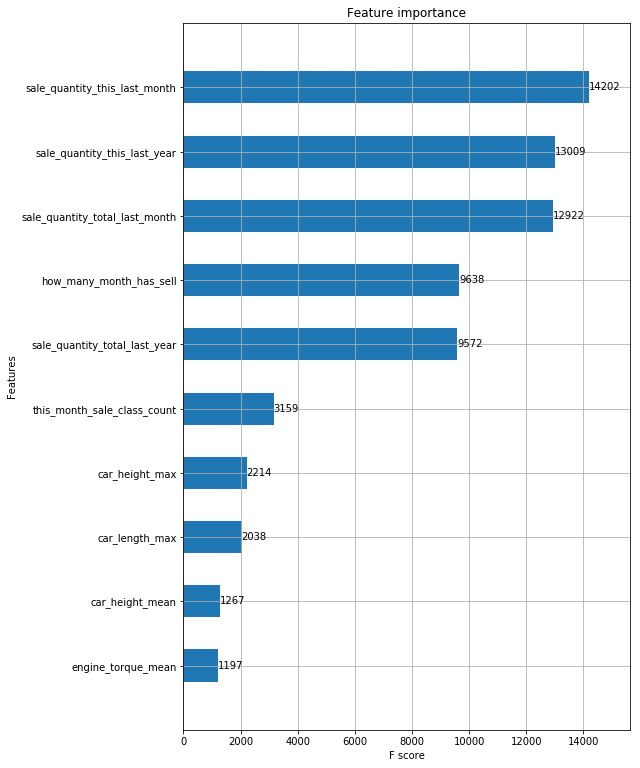

In [37]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

## 全特征 + 五窗口 std

In [38]:
train = pd.read_csv('../../raw/LiChuan/trainallfeatures2.csv')
# test = pd.read_csv('../../raw/LiChuan/test_feature.csv')
submit = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [39]:
# 去掉 2012 年数据, 噪音太多
train = train[train['year']!=2012]

In [40]:
# year 和 month 进行 one-hot 编码
train.drop_duplicates(inplace=True)
labels = train.sale_quantity[:8120]
train = train.drop(['class_id','sale_quantity', 'sale_date'], axis=1)

# train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train['year'], prefix='year')
month_dummies = pd.get_dummies(train['month'], prefix='month')
train = pd.concat([train, year_dummies], axis=1)
train = pd.concat([train, month_dummies], axis=1)
train = train.drop(['year', 'month'], axis=1)
train.fillna(0.0, inplace=True)

test = train[8120:].reset_index(drop=True)
train = train[:8120].reset_index(drop=True)

In [41]:
# 获取 2017-10 作为测试集
test_X = train[-140:]
test_Y = labels[-140:]

In [42]:
# 2012-01 至 2017-10 作为训练集
train_X = train[:-140]
train_Y = labels[:-140]

In [43]:
# RMSE = 125
rmses = []
trainset = xgb.DMatrix(train_X,label=train_Y)
testset = xgb.DMatrix(test_X)

params = {
'booster': 'gbtree', # 基于树的模型进行计算
'objective': 'reg:linear', # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 5, # 树的最大深度。缺省值为6
'lambda': 10, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
'seed': 5,
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=4000,evals=watchlist)
predict_test_X = model.predict(testset)
rmsetmp = sp.sqrt(sp.mean((test_Y - predict_test_X) ** 2))

print('This time rmse is: '+ str(rmsetmp))
rmses.append(rmsetmp)

[0]	train-rmse:446.922
[1]	train-rmse:353.068
[2]	train-rmse:288.046
[3]	train-rmse:242.967
[4]	train-rmse:212.398
[5]	train-rmse:194.794
[6]	train-rmse:178.905
[7]	train-rmse:167.996
[8]	train-rmse:161.591
[9]	train-rmse:154.939
[10]	train-rmse:148.164
[11]	train-rmse:143.387
[12]	train-rmse:140.657
[13]	train-rmse:136.175
[14]	train-rmse:133.016
[15]	train-rmse:131.676
[16]	train-rmse:129.675
[17]	train-rmse:127.564
[18]	train-rmse:124.978
[19]	train-rmse:123.961
[20]	train-rmse:122.057
[21]	train-rmse:120.376
[22]	train-rmse:118.973
[23]	train-rmse:117.792
[24]	train-rmse:116.4
[25]	train-rmse:114.962
[26]	train-rmse:113.284
[27]	train-rmse:111.306
[28]	train-rmse:109.985
[29]	train-rmse:107.883
[30]	train-rmse:106.168
[31]	train-rmse:105.341
[32]	train-rmse:103.576
[33]	train-rmse:102.786
[34]	train-rmse:102.076
[35]	train-rmse:99.7877
[36]	train-rmse:98.932
[37]	train-rmse:98.2672
[38]	train-rmse:97.1442
[39]	train-rmse:96.3359
[40]	train-rmse:95.7136
[41]	train-rmse:94.868
[42]	t

[334]	train-rmse:23.4494
[335]	train-rmse:23.3953
[336]	train-rmse:23.343
[337]	train-rmse:23.2882
[338]	train-rmse:23.2066
[339]	train-rmse:23.1495
[340]	train-rmse:23.0964
[341]	train-rmse:23.0163
[342]	train-rmse:22.9683
[343]	train-rmse:22.9241
[344]	train-rmse:22.8351
[345]	train-rmse:22.738
[346]	train-rmse:22.6496
[347]	train-rmse:22.5852
[348]	train-rmse:22.4824
[349]	train-rmse:22.4039
[350]	train-rmse:22.3514
[351]	train-rmse:22.2693
[352]	train-rmse:22.1898
[353]	train-rmse:22.094
[354]	train-rmse:22.0067
[355]	train-rmse:21.9227
[356]	train-rmse:21.8663
[357]	train-rmse:21.8042
[358]	train-rmse:21.7069
[359]	train-rmse:21.6627
[360]	train-rmse:21.5916
[361]	train-rmse:21.5366
[362]	train-rmse:21.478
[363]	train-rmse:21.4108
[364]	train-rmse:21.3697
[365]	train-rmse:21.2791
[366]	train-rmse:21.2467
[367]	train-rmse:21.2021
[368]	train-rmse:21.1142
[369]	train-rmse:21.0493
[370]	train-rmse:20.9741
[371]	train-rmse:20.9005
[372]	train-rmse:20.835
[373]	train-rmse:20.767
[374]	

[663]	train-rmse:9.16115
[664]	train-rmse:9.13254
[665]	train-rmse:9.09965
[666]	train-rmse:9.06808
[667]	train-rmse:9.04029
[668]	train-rmse:8.99905
[669]	train-rmse:8.98126
[670]	train-rmse:8.95607
[671]	train-rmse:8.94211
[672]	train-rmse:8.91291
[673]	train-rmse:8.87561
[674]	train-rmse:8.84414
[675]	train-rmse:8.82733
[676]	train-rmse:8.79599
[677]	train-rmse:8.76801
[678]	train-rmse:8.75096
[679]	train-rmse:8.73215
[680]	train-rmse:8.7062
[681]	train-rmse:8.67101
[682]	train-rmse:8.63703
[683]	train-rmse:8.61053
[684]	train-rmse:8.59767
[685]	train-rmse:8.58549
[686]	train-rmse:8.56564
[687]	train-rmse:8.53059
[688]	train-rmse:8.51125
[689]	train-rmse:8.49495
[690]	train-rmse:8.47144
[691]	train-rmse:8.45665
[692]	train-rmse:8.43843
[693]	train-rmse:8.41444
[694]	train-rmse:8.40104
[695]	train-rmse:8.38108
[696]	train-rmse:8.35531
[697]	train-rmse:8.34598
[698]	train-rmse:8.32002
[699]	train-rmse:8.30574
[700]	train-rmse:8.28739
[701]	train-rmse:8.27553
[702]	train-rmse:8.25975
[

[992]	train-rmse:4.22705
[993]	train-rmse:4.22181
[994]	train-rmse:4.21186
[995]	train-rmse:4.20141
[996]	train-rmse:4.19391
[997]	train-rmse:4.18559
[998]	train-rmse:4.17752
[999]	train-rmse:4.16851
[1000]	train-rmse:4.1581
[1001]	train-rmse:4.14965
[1002]	train-rmse:4.14271
[1003]	train-rmse:4.13642
[1004]	train-rmse:4.12635
[1005]	train-rmse:4.11935
[1006]	train-rmse:4.10907
[1007]	train-rmse:4.1008
[1008]	train-rmse:4.09413
[1009]	train-rmse:4.08282
[1010]	train-rmse:4.0738
[1011]	train-rmse:4.06486
[1012]	train-rmse:4.05335
[1013]	train-rmse:4.04376
[1014]	train-rmse:4.03654
[1015]	train-rmse:4.02629
[1016]	train-rmse:4.02389
[1017]	train-rmse:4.01712
[1018]	train-rmse:4.01192
[1019]	train-rmse:4.0052
[1020]	train-rmse:3.99585
[1021]	train-rmse:3.98439
[1022]	train-rmse:3.97743
[1023]	train-rmse:3.97473
[1024]	train-rmse:3.96562
[1025]	train-rmse:3.95645
[1026]	train-rmse:3.94695
[1027]	train-rmse:3.94073
[1028]	train-rmse:3.92853
[1029]	train-rmse:3.92243
[1030]	train-rmse:3.9164

[1309]	train-rmse:2.32553
[1310]	train-rmse:2.32344
[1311]	train-rmse:2.31975
[1312]	train-rmse:2.31486
[1313]	train-rmse:2.30965
[1314]	train-rmse:2.30536
[1315]	train-rmse:2.29993
[1316]	train-rmse:2.29446
[1317]	train-rmse:2.29014
[1318]	train-rmse:2.28633
[1319]	train-rmse:2.2835
[1320]	train-rmse:2.27813
[1321]	train-rmse:2.27405
[1322]	train-rmse:2.27078
[1323]	train-rmse:2.2684
[1324]	train-rmse:2.26426
[1325]	train-rmse:2.26199
[1326]	train-rmse:2.25922
[1327]	train-rmse:2.25641
[1328]	train-rmse:2.25363
[1329]	train-rmse:2.24847
[1330]	train-rmse:2.24476
[1331]	train-rmse:2.24156
[1332]	train-rmse:2.23727
[1333]	train-rmse:2.23537
[1334]	train-rmse:2.23181
[1335]	train-rmse:2.22785
[1336]	train-rmse:2.22511
[1337]	train-rmse:2.22102
[1338]	train-rmse:2.21609
[1339]	train-rmse:2.21081
[1340]	train-rmse:2.20856
[1341]	train-rmse:2.20444
[1342]	train-rmse:2.19855
[1343]	train-rmse:2.19425
[1344]	train-rmse:2.19048
[1345]	train-rmse:2.18841
[1346]	train-rmse:2.18605
[1347]	train-r

[1626]	train-rmse:1.41966
[1627]	train-rmse:1.41814
[1628]	train-rmse:1.41618
[1629]	train-rmse:1.4143
[1630]	train-rmse:1.41288
[1631]	train-rmse:1.41118
[1632]	train-rmse:1.40978
[1633]	train-rmse:1.4072
[1634]	train-rmse:1.40541
[1635]	train-rmse:1.40411
[1636]	train-rmse:1.40173
[1637]	train-rmse:1.39355
[1638]	train-rmse:1.39261
[1639]	train-rmse:1.39098
[1640]	train-rmse:1.38846
[1641]	train-rmse:1.38673
[1642]	train-rmse:1.38359
[1643]	train-rmse:1.38093
[1644]	train-rmse:1.37988
[1645]	train-rmse:1.37793
[1646]	train-rmse:1.3765
[1647]	train-rmse:1.37506
[1648]	train-rmse:1.3738
[1649]	train-rmse:1.37162
[1650]	train-rmse:1.3697
[1651]	train-rmse:1.36701
[1652]	train-rmse:1.36562
[1653]	train-rmse:1.36238
[1654]	train-rmse:1.35971
[1655]	train-rmse:1.3585
[1656]	train-rmse:1.35523
[1657]	train-rmse:1.35284
[1658]	train-rmse:1.35087
[1659]	train-rmse:1.34936
[1660]	train-rmse:1.34791
[1661]	train-rmse:1.34693
[1662]	train-rmse:1.34597
[1663]	train-rmse:1.34449
[1664]	train-rmse:

[1941]	train-rmse:0.939722
[1942]	train-rmse:0.938408
[1943]	train-rmse:0.9374
[1944]	train-rmse:0.936558
[1945]	train-rmse:0.935491
[1946]	train-rmse:0.934041
[1947]	train-rmse:0.933331
[1948]	train-rmse:0.932511
[1949]	train-rmse:0.931545
[1950]	train-rmse:0.930545
[1951]	train-rmse:0.929521
[1952]	train-rmse:0.929106
[1953]	train-rmse:0.928138
[1954]	train-rmse:0.927317
[1955]	train-rmse:0.925829
[1956]	train-rmse:0.923936
[1957]	train-rmse:0.923026
[1958]	train-rmse:0.922265
[1959]	train-rmse:0.921604
[1960]	train-rmse:0.920388
[1961]	train-rmse:0.919545
[1962]	train-rmse:0.918935
[1963]	train-rmse:0.918182
[1964]	train-rmse:0.917524
[1965]	train-rmse:0.916459
[1966]	train-rmse:0.915375
[1967]	train-rmse:0.914465
[1968]	train-rmse:0.912095
[1969]	train-rmse:0.911157
[1970]	train-rmse:0.909596
[1971]	train-rmse:0.908589
[1972]	train-rmse:0.907916
[1973]	train-rmse:0.907066
[1974]	train-rmse:0.90589
[1975]	train-rmse:0.905027
[1976]	train-rmse:0.903799
[1977]	train-rmse:0.902327
[197

[2246]	train-rmse:0.668512
[2247]	train-rmse:0.667912
[2248]	train-rmse:0.667248
[2249]	train-rmse:0.666362
[2250]	train-rmse:0.665909
[2251]	train-rmse:0.665227
[2252]	train-rmse:0.664321
[2253]	train-rmse:0.663606
[2254]	train-rmse:0.662499
[2255]	train-rmse:0.662141
[2256]	train-rmse:0.661751
[2257]	train-rmse:0.661168
[2258]	train-rmse:0.660641
[2259]	train-rmse:0.659958
[2260]	train-rmse:0.659518
[2261]	train-rmse:0.65871
[2262]	train-rmse:0.658057
[2263]	train-rmse:0.657039
[2264]	train-rmse:0.655851
[2265]	train-rmse:0.654861
[2266]	train-rmse:0.654098
[2267]	train-rmse:0.653023
[2268]	train-rmse:0.652578
[2269]	train-rmse:0.652054
[2270]	train-rmse:0.651584
[2271]	train-rmse:0.650737
[2272]	train-rmse:0.650053
[2273]	train-rmse:0.649182
[2274]	train-rmse:0.647418
[2275]	train-rmse:0.646772
[2276]	train-rmse:0.646512
[2277]	train-rmse:0.645893
[2278]	train-rmse:0.645397
[2279]	train-rmse:0.644959
[2280]	train-rmse:0.644543
[2281]	train-rmse:0.644017
[2282]	train-rmse:0.643539
[2

[2551]	train-rmse:0.499206
[2552]	train-rmse:0.498638
[2553]	train-rmse:0.49833
[2554]	train-rmse:0.497887
[2555]	train-rmse:0.497459
[2556]	train-rmse:0.497197
[2557]	train-rmse:0.496683
[2558]	train-rmse:0.496306
[2559]	train-rmse:0.495671
[2560]	train-rmse:0.495426
[2561]	train-rmse:0.495053
[2562]	train-rmse:0.494628
[2563]	train-rmse:0.494281
[2564]	train-rmse:0.493787
[2565]	train-rmse:0.493301
[2566]	train-rmse:0.493135
[2567]	train-rmse:0.4927
[2568]	train-rmse:0.492078
[2569]	train-rmse:0.491679
[2570]	train-rmse:0.491204
[2571]	train-rmse:0.490606
[2572]	train-rmse:0.490111
[2573]	train-rmse:0.489578
[2574]	train-rmse:0.488928
[2575]	train-rmse:0.488499
[2576]	train-rmse:0.488101
[2577]	train-rmse:0.48763
[2578]	train-rmse:0.487313
[2579]	train-rmse:0.486572
[2580]	train-rmse:0.486246
[2581]	train-rmse:0.485922
[2582]	train-rmse:0.485206
[2583]	train-rmse:0.48493
[2584]	train-rmse:0.484521
[2585]	train-rmse:0.483877
[2586]	train-rmse:0.483194
[2587]	train-rmse:0.482694
[2588]

[2856]	train-rmse:0.385802
[2857]	train-rmse:0.385482
[2858]	train-rmse:0.385256
[2859]	train-rmse:0.385031
[2860]	train-rmse:0.384688
[2861]	train-rmse:0.384503
[2862]	train-rmse:0.384144
[2863]	train-rmse:0.383744
[2864]	train-rmse:0.383398
[2865]	train-rmse:0.383053
[2866]	train-rmse:0.38271
[2867]	train-rmse:0.382468
[2868]	train-rmse:0.382135
[2869]	train-rmse:0.381647
[2870]	train-rmse:0.381306
[2871]	train-rmse:0.381038
[2872]	train-rmse:0.380712
[2873]	train-rmse:0.380317
[2874]	train-rmse:0.380127
[2875]	train-rmse:0.379814
[2876]	train-rmse:0.379494
[2877]	train-rmse:0.379142
[2878]	train-rmse:0.378824
[2879]	train-rmse:0.378567
[2880]	train-rmse:0.378386
[2881]	train-rmse:0.378133
[2882]	train-rmse:0.377962
[2883]	train-rmse:0.377476
[2884]	train-rmse:0.377097
[2885]	train-rmse:0.376795
[2886]	train-rmse:0.376506
[2887]	train-rmse:0.376368
[2888]	train-rmse:0.376048
[2889]	train-rmse:0.37565
[2890]	train-rmse:0.375377
[2891]	train-rmse:0.375152
[2892]	train-rmse:0.374846
[28

[3161]	train-rmse:0.311651
[3162]	train-rmse:0.311566
[3163]	train-rmse:0.31141
[3164]	train-rmse:0.311294
[3165]	train-rmse:0.311084
[3166]	train-rmse:0.311001
[3167]	train-rmse:0.310928
[3168]	train-rmse:0.310891
[3169]	train-rmse:0.31075
[3170]	train-rmse:0.310692
[3171]	train-rmse:0.310591
[3172]	train-rmse:0.310296
[3173]	train-rmse:0.309852
[3174]	train-rmse:0.309615
[3175]	train-rmse:0.30946
[3176]	train-rmse:0.309347
[3177]	train-rmse:0.309054
[3178]	train-rmse:0.308841
[3179]	train-rmse:0.308665
[3180]	train-rmse:0.308445
[3181]	train-rmse:0.308133
[3182]	train-rmse:0.307633
[3183]	train-rmse:0.307461
[3184]	train-rmse:0.307392
[3185]	train-rmse:0.307005
[3186]	train-rmse:0.306694
[3187]	train-rmse:0.306558
[3188]	train-rmse:0.306404
[3189]	train-rmse:0.306283
[3190]	train-rmse:0.306202
[3191]	train-rmse:0.305892
[3192]	train-rmse:0.305788
[3193]	train-rmse:0.305658
[3194]	train-rmse:0.30546
[3195]	train-rmse:0.305437
[3196]	train-rmse:0.305124
[3197]	train-rmse:0.305022
[3198

[3466]	train-rmse:0.261844
[3467]	train-rmse:0.26164
[3468]	train-rmse:0.261498
[3469]	train-rmse:0.261329
[3470]	train-rmse:0.261206
[3471]	train-rmse:0.26109
[3472]	train-rmse:0.260856
[3473]	train-rmse:0.260503
[3474]	train-rmse:0.260449
[3475]	train-rmse:0.260326
[3476]	train-rmse:0.260108
[3477]	train-rmse:0.259747
[3478]	train-rmse:0.259647
[3479]	train-rmse:0.259523
[3480]	train-rmse:0.259335
[3481]	train-rmse:0.259244
[3482]	train-rmse:0.259133
[3483]	train-rmse:0.259007
[3484]	train-rmse:0.258878
[3485]	train-rmse:0.258715
[3486]	train-rmse:0.258544
[3487]	train-rmse:0.258511
[3488]	train-rmse:0.25843
[3489]	train-rmse:0.258148
[3490]	train-rmse:0.2579
[3491]	train-rmse:0.257713
[3492]	train-rmse:0.257446
[3493]	train-rmse:0.257282
[3494]	train-rmse:0.257155
[3495]	train-rmse:0.257033
[3496]	train-rmse:0.257013
[3497]	train-rmse:0.256934
[3498]	train-rmse:0.256805
[3499]	train-rmse:0.25654
[3500]	train-rmse:0.256408
[3501]	train-rmse:0.256114
[3502]	train-rmse:0.255898
[3503]	

[3771]	train-rmse:0.22835
[3772]	train-rmse:0.228235
[3773]	train-rmse:0.228071
[3774]	train-rmse:0.227987
[3775]	train-rmse:0.227919
[3776]	train-rmse:0.227895
[3777]	train-rmse:0.227793
[3778]	train-rmse:0.227662
[3779]	train-rmse:0.227553
[3780]	train-rmse:0.227373
[3781]	train-rmse:0.227337
[3782]	train-rmse:0.227256
[3783]	train-rmse:0.227225
[3784]	train-rmse:0.227088
[3785]	train-rmse:0.227051
[3786]	train-rmse:0.227022
[3787]	train-rmse:0.226858
[3788]	train-rmse:0.226825
[3789]	train-rmse:0.226798
[3790]	train-rmse:0.226754
[3791]	train-rmse:0.226671
[3792]	train-rmse:0.226628
[3793]	train-rmse:0.226604
[3794]	train-rmse:0.226558
[3795]	train-rmse:0.226484
[3796]	train-rmse:0.226398
[3797]	train-rmse:0.226098
[3798]	train-rmse:0.226042
[3799]	train-rmse:0.226024
[3800]	train-rmse:0.225903
[3801]	train-rmse:0.225735
[3802]	train-rmse:0.225641
[3803]	train-rmse:0.225592
[3804]	train-rmse:0.225443
[3805]	train-rmse:0.225434
[3806]	train-rmse:0.225337
[3807]	train-rmse:0.225293
[3

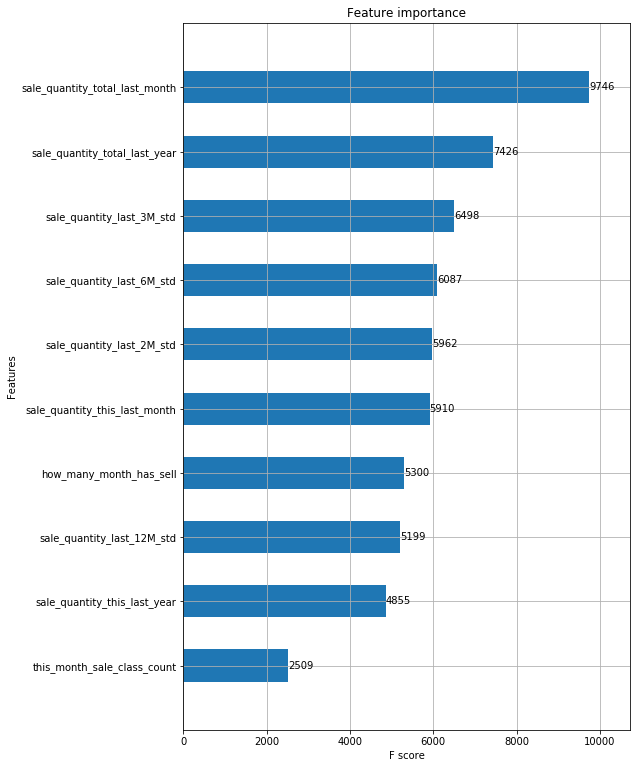

In [44]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

## 测试其他

In [66]:
rmses = []
for i in range(5):    
    train_X,test_X, train_y, test_y = train_test_split(train,  
                                                        labels,  
                                                        test_size = 0.05)
    
    trainset = xgb.DMatrix(train_X,label=train_y)
    testset = xgb.DMatrix(test_X)
    
    params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L2 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
    watchlist = [(trainset,'train')]
    model3 = xgb.train(params, trainset, num_boost_round=4000, evals=watchlist)
    predict_test_X = model3.predict(testset)
    rmsetmp = sp.sqrt(sp.mean((test_y - predict_test_X) ** 2))
    
    print('This time rmse is: '+ str(rmsetmp))
    rmses.append(rmsetmp)
    
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum/len(list)
    
print('Mean rmse of these is:' + str(Get_Average(rmses)))

[0]	train-rmse:440.981
[1]	train-rmse:343.862
[2]	train-rmse:280.972
[3]	train-rmse:237.132
[4]	train-rmse:208.275
[5]	train-rmse:189.695
[6]	train-rmse:177.489
[7]	train-rmse:168.571
[8]	train-rmse:159.776
[9]	train-rmse:151.839
[10]	train-rmse:146.373
[11]	train-rmse:141.772
[12]	train-rmse:138.085
[13]	train-rmse:134.777
[14]	train-rmse:130.773
[15]	train-rmse:128.297
[16]	train-rmse:126.044
[17]	train-rmse:122.886
[18]	train-rmse:121.206
[19]	train-rmse:119.1
[20]	train-rmse:115.622
[21]	train-rmse:112.608
[22]	train-rmse:110.886
[23]	train-rmse:108.996
[24]	train-rmse:108.358
[25]	train-rmse:106.994
[26]	train-rmse:105.254
[27]	train-rmse:103.479
[28]	train-rmse:102.183
[29]	train-rmse:100.784
[30]	train-rmse:99.8377
[31]	train-rmse:98.8715
[32]	train-rmse:98.2669
[33]	train-rmse:97.7039
[34]	train-rmse:96.7589
[35]	train-rmse:95.6451
[36]	train-rmse:95.3452
[37]	train-rmse:94.2252
[38]	train-rmse:93.6414
[39]	train-rmse:92.9796
[40]	train-rmse:91.7529
[41]	train-rmse:90.9976
[42]

[334]	train-rmse:19.7293
[335]	train-rmse:19.6406
[336]	train-rmse:19.5624
[337]	train-rmse:19.5094
[338]	train-rmse:19.4359
[339]	train-rmse:19.3459
[340]	train-rmse:19.2677
[341]	train-rmse:19.2028
[342]	train-rmse:19.1564
[343]	train-rmse:19.0944
[344]	train-rmse:19.0151
[345]	train-rmse:18.9611
[346]	train-rmse:18.8982
[347]	train-rmse:18.8154
[348]	train-rmse:18.7384
[349]	train-rmse:18.6646
[350]	train-rmse:18.5859
[351]	train-rmse:18.5075
[352]	train-rmse:18.4447
[353]	train-rmse:18.3511
[354]	train-rmse:18.2743
[355]	train-rmse:18.24
[356]	train-rmse:18.1841
[357]	train-rmse:18.1046
[358]	train-rmse:18.0127
[359]	train-rmse:17.9387
[360]	train-rmse:17.8278
[361]	train-rmse:17.7511
[362]	train-rmse:17.6557
[363]	train-rmse:17.621
[364]	train-rmse:17.522
[365]	train-rmse:17.4465
[366]	train-rmse:17.4054
[367]	train-rmse:17.35
[368]	train-rmse:17.2721
[369]	train-rmse:17.2202
[370]	train-rmse:17.1774
[371]	train-rmse:17.1374
[372]	train-rmse:17.0808
[373]	train-rmse:17.0258
[374]	

[664]	train-rmse:6.76517
[665]	train-rmse:6.74107
[666]	train-rmse:6.71624
[667]	train-rmse:6.69912
[668]	train-rmse:6.68244
[669]	train-rmse:6.65887
[670]	train-rmse:6.64288
[671]	train-rmse:6.62785
[672]	train-rmse:6.6078
[673]	train-rmse:6.58957
[674]	train-rmse:6.55039
[675]	train-rmse:6.53073
[676]	train-rmse:6.52024
[677]	train-rmse:6.49846
[678]	train-rmse:6.47899
[679]	train-rmse:6.46134
[680]	train-rmse:6.42951
[681]	train-rmse:6.41345
[682]	train-rmse:6.38775
[683]	train-rmse:6.36529
[684]	train-rmse:6.34141
[685]	train-rmse:6.31861
[686]	train-rmse:6.29796
[687]	train-rmse:6.27649
[688]	train-rmse:6.26107
[689]	train-rmse:6.24275
[690]	train-rmse:6.21861
[691]	train-rmse:6.19839
[692]	train-rmse:6.18095
[693]	train-rmse:6.16397
[694]	train-rmse:6.14395
[695]	train-rmse:6.12791
[696]	train-rmse:6.11285
[697]	train-rmse:6.09639
[698]	train-rmse:6.07789
[699]	train-rmse:6.05505
[700]	train-rmse:6.04417
[701]	train-rmse:6.02431
[702]	train-rmse:6.00775
[703]	train-rmse:5.98723
[

[993]	train-rmse:2.90208
[994]	train-rmse:2.89654
[995]	train-rmse:2.89185
[996]	train-rmse:2.88684
[997]	train-rmse:2.88021
[998]	train-rmse:2.87603
[999]	train-rmse:2.8664
[1000]	train-rmse:2.86077
[1001]	train-rmse:2.84203
[1002]	train-rmse:2.83465
[1003]	train-rmse:2.83085
[1004]	train-rmse:2.82359
[1005]	train-rmse:2.81638
[1006]	train-rmse:2.81146
[1007]	train-rmse:2.80435
[1008]	train-rmse:2.79865
[1009]	train-rmse:2.79474
[1010]	train-rmse:2.78544
[1011]	train-rmse:2.77951
[1012]	train-rmse:2.77311
[1013]	train-rmse:2.76439
[1014]	train-rmse:2.75863
[1015]	train-rmse:2.75309
[1016]	train-rmse:2.7492
[1017]	train-rmse:2.74429
[1018]	train-rmse:2.73746
[1019]	train-rmse:2.73191
[1020]	train-rmse:2.72336
[1021]	train-rmse:2.71941
[1022]	train-rmse:2.71286
[1023]	train-rmse:2.70887
[1024]	train-rmse:2.70181
[1025]	train-rmse:2.69996
[1026]	train-rmse:2.69356
[1027]	train-rmse:2.68733
[1028]	train-rmse:2.68292
[1029]	train-rmse:2.67787
[1030]	train-rmse:2.67397
[1031]	train-rmse:2.6

[1310]	train-rmse:1.52178
[1311]	train-rmse:1.52041
[1312]	train-rmse:1.51627
[1313]	train-rmse:1.51452
[1314]	train-rmse:1.51308
[1315]	train-rmse:1.50963
[1316]	train-rmse:1.50702
[1317]	train-rmse:1.5038
[1318]	train-rmse:1.50086
[1319]	train-rmse:1.49766
[1320]	train-rmse:1.49455
[1321]	train-rmse:1.49339
[1322]	train-rmse:1.4919
[1323]	train-rmse:1.48692
[1324]	train-rmse:1.48361
[1325]	train-rmse:1.48121
[1326]	train-rmse:1.47825
[1327]	train-rmse:1.47498
[1328]	train-rmse:1.47288
[1329]	train-rmse:1.47042
[1330]	train-rmse:1.46684
[1331]	train-rmse:1.46274
[1332]	train-rmse:1.46084
[1333]	train-rmse:1.45967
[1334]	train-rmse:1.45655
[1335]	train-rmse:1.45487
[1336]	train-rmse:1.45264
[1337]	train-rmse:1.4475
[1338]	train-rmse:1.44405
[1339]	train-rmse:1.43896
[1340]	train-rmse:1.43492
[1341]	train-rmse:1.43192
[1342]	train-rmse:1.4271
[1343]	train-rmse:1.4253
[1344]	train-rmse:1.42267
[1345]	train-rmse:1.42136
[1346]	train-rmse:1.41936
[1347]	train-rmse:1.41714
[1348]	train-rmse

[1625]	train-rmse:0.90713
[1626]	train-rmse:0.905994
[1627]	train-rmse:0.903329
[1628]	train-rmse:0.902338
[1629]	train-rmse:0.901198
[1630]	train-rmse:0.899507
[1631]	train-rmse:0.897961
[1632]	train-rmse:0.896285
[1633]	train-rmse:0.895339
[1634]	train-rmse:0.89439
[1635]	train-rmse:0.893396
[1636]	train-rmse:0.89161
[1637]	train-rmse:0.890077
[1638]	train-rmse:0.888412
[1639]	train-rmse:0.886582
[1640]	train-rmse:0.885898
[1641]	train-rmse:0.884194
[1642]	train-rmse:0.883191
[1643]	train-rmse:0.881937
[1644]	train-rmse:0.880533
[1645]	train-rmse:0.879433
[1646]	train-rmse:0.8776
[1647]	train-rmse:0.876447
[1648]	train-rmse:0.875347
[1649]	train-rmse:0.874115
[1650]	train-rmse:0.873197
[1651]	train-rmse:0.871646
[1652]	train-rmse:0.870815
[1653]	train-rmse:0.869662
[1654]	train-rmse:0.868708
[1655]	train-rmse:0.866372
[1656]	train-rmse:0.865417
[1657]	train-rmse:0.864297
[1658]	train-rmse:0.863421
[1659]	train-rmse:0.861823
[1660]	train-rmse:0.861096
[1661]	train-rmse:0.859572
[1662]

[1930]	train-rmse:0.602003
[1931]	train-rmse:0.60077
[1932]	train-rmse:0.599855
[1933]	train-rmse:0.598949
[1934]	train-rmse:0.596949
[1935]	train-rmse:0.596232
[1936]	train-rmse:0.595679
[1937]	train-rmse:0.595083
[1938]	train-rmse:0.59405
[1939]	train-rmse:0.593196
[1940]	train-rmse:0.592628
[1941]	train-rmse:0.592041
[1942]	train-rmse:0.591456
[1943]	train-rmse:0.590913
[1944]	train-rmse:0.590515
[1945]	train-rmse:0.589612
[1946]	train-rmse:0.588957
[1947]	train-rmse:0.587937
[1948]	train-rmse:0.58735
[1949]	train-rmse:0.586876
[1950]	train-rmse:0.586305
[1951]	train-rmse:0.58503
[1952]	train-rmse:0.584483
[1953]	train-rmse:0.583426
[1954]	train-rmse:0.582995
[1955]	train-rmse:0.582376
[1956]	train-rmse:0.581556
[1957]	train-rmse:0.580844
[1958]	train-rmse:0.580068
[1959]	train-rmse:0.579269
[1960]	train-rmse:0.578264
[1961]	train-rmse:0.577514
[1962]	train-rmse:0.576982
[1963]	train-rmse:0.575432
[1964]	train-rmse:0.574934
[1965]	train-rmse:0.574133
[1966]	train-rmse:0.573474
[1967

[2235]	train-rmse:0.427536
[2236]	train-rmse:0.427148
[2237]	train-rmse:0.426388
[2238]	train-rmse:0.426045
[2239]	train-rmse:0.425663
[2240]	train-rmse:0.425402
[2241]	train-rmse:0.425052
[2242]	train-rmse:0.424053
[2243]	train-rmse:0.423586
[2244]	train-rmse:0.423232
[2245]	train-rmse:0.422793
[2246]	train-rmse:0.422614
[2247]	train-rmse:0.422233
[2248]	train-rmse:0.421794
[2249]	train-rmse:0.420654
[2250]	train-rmse:0.419799
[2251]	train-rmse:0.419365
[2252]	train-rmse:0.418996
[2253]	train-rmse:0.418089
[2254]	train-rmse:0.417621
[2255]	train-rmse:0.416887
[2256]	train-rmse:0.416206
[2257]	train-rmse:0.415605
[2258]	train-rmse:0.415254
[2259]	train-rmse:0.414725
[2260]	train-rmse:0.414434
[2261]	train-rmse:0.413944
[2262]	train-rmse:0.413495
[2263]	train-rmse:0.41324
[2264]	train-rmse:0.412939
[2265]	train-rmse:0.412655
[2266]	train-rmse:0.412429
[2267]	train-rmse:0.412072
[2268]	train-rmse:0.411897
[2269]	train-rmse:0.411536
[2270]	train-rmse:0.411145
[2271]	train-rmse:0.410871
[2

[2540]	train-rmse:0.314273
[2541]	train-rmse:0.313888
[2542]	train-rmse:0.313609
[2543]	train-rmse:0.313381
[2544]	train-rmse:0.313081
[2545]	train-rmse:0.312838
[2546]	train-rmse:0.312471
[2547]	train-rmse:0.31223
[2548]	train-rmse:0.311916
[2549]	train-rmse:0.311447
[2550]	train-rmse:0.311137
[2551]	train-rmse:0.310876
[2552]	train-rmse:0.310604
[2553]	train-rmse:0.310289
[2554]	train-rmse:0.310132
[2555]	train-rmse:0.309858
[2556]	train-rmse:0.309586
[2557]	train-rmse:0.309206
[2558]	train-rmse:0.308891
[2559]	train-rmse:0.308674
[2560]	train-rmse:0.308507
[2561]	train-rmse:0.308133
[2562]	train-rmse:0.307923
[2563]	train-rmse:0.307719
[2564]	train-rmse:0.307556
[2565]	train-rmse:0.307038
[2566]	train-rmse:0.306628
[2567]	train-rmse:0.30627
[2568]	train-rmse:0.305984
[2569]	train-rmse:0.30581
[2570]	train-rmse:0.305432
[2571]	train-rmse:0.305276
[2572]	train-rmse:0.304874
[2573]	train-rmse:0.304532
[2574]	train-rmse:0.304281
[2575]	train-rmse:0.303958
[2576]	train-rmse:0.303745
[257

[2845]	train-rmse:0.237022
[2846]	train-rmse:0.236928
[2847]	train-rmse:0.236624
[2848]	train-rmse:0.236441
[2849]	train-rmse:0.236294
[2850]	train-rmse:0.236058
[2851]	train-rmse:0.235846
[2852]	train-rmse:0.235738
[2853]	train-rmse:0.235513
[2854]	train-rmse:0.235367
[2855]	train-rmse:0.235083
[2856]	train-rmse:0.234968
[2857]	train-rmse:0.234758
[2858]	train-rmse:0.2346
[2859]	train-rmse:0.234351
[2860]	train-rmse:0.234231
[2861]	train-rmse:0.234068
[2862]	train-rmse:0.233746
[2863]	train-rmse:0.233532
[2864]	train-rmse:0.233452
[2865]	train-rmse:0.233251
[2866]	train-rmse:0.233117
[2867]	train-rmse:0.232917
[2868]	train-rmse:0.232633
[2869]	train-rmse:0.232456
[2870]	train-rmse:0.232231
[2871]	train-rmse:0.232104
[2872]	train-rmse:0.231766
[2873]	train-rmse:0.231554
[2874]	train-rmse:0.231245
[2875]	train-rmse:0.231012
[2876]	train-rmse:0.23085
[2877]	train-rmse:0.230701
[2878]	train-rmse:0.230433
[2879]	train-rmse:0.230315
[2880]	train-rmse:0.230169
[2881]	train-rmse:0.229783
[288

[3150]	train-rmse:0.181903
[3151]	train-rmse:0.18178
[3152]	train-rmse:0.181685
[3153]	train-rmse:0.181514
[3154]	train-rmse:0.181383
[3155]	train-rmse:0.181216
[3156]	train-rmse:0.180988
[3157]	train-rmse:0.180785
[3158]	train-rmse:0.180674
[3159]	train-rmse:0.18049
[3160]	train-rmse:0.180362
[3161]	train-rmse:0.180179
[3162]	train-rmse:0.180074
[3163]	train-rmse:0.179966
[3164]	train-rmse:0.179796
[3165]	train-rmse:0.179591
[3166]	train-rmse:0.179358
[3167]	train-rmse:0.179257
[3168]	train-rmse:0.179161
[3169]	train-rmse:0.179035
[3170]	train-rmse:0.178726
[3171]	train-rmse:0.178628
[3172]	train-rmse:0.178532
[3173]	train-rmse:0.178393
[3174]	train-rmse:0.178155
[3175]	train-rmse:0.177985
[3176]	train-rmse:0.177854
[3177]	train-rmse:0.177624
[3178]	train-rmse:0.177476
[3179]	train-rmse:0.177346
[3180]	train-rmse:0.177206
[3181]	train-rmse:0.17708
[3182]	train-rmse:0.176907
[3183]	train-rmse:0.176813
[3184]	train-rmse:0.176621
[3185]	train-rmse:0.17654
[3186]	train-rmse:0.17637
[3187]

[3455]	train-rmse:0.143467
[3456]	train-rmse:0.143392
[3457]	train-rmse:0.143326
[3458]	train-rmse:0.143274
[3459]	train-rmse:0.143196
[3460]	train-rmse:0.143013
[3461]	train-rmse:0.142963
[3462]	train-rmse:0.142858
[3463]	train-rmse:0.142695
[3464]	train-rmse:0.142587
[3465]	train-rmse:0.142499
[3466]	train-rmse:0.142387
[3467]	train-rmse:0.142301
[3468]	train-rmse:0.142222
[3469]	train-rmse:0.142195
[3470]	train-rmse:0.142084
[3471]	train-rmse:0.141919
[3472]	train-rmse:0.141846
[3473]	train-rmse:0.14174
[3474]	train-rmse:0.141631
[3475]	train-rmse:0.141445
[3476]	train-rmse:0.141295
[3477]	train-rmse:0.141199
[3478]	train-rmse:0.141084
[3479]	train-rmse:0.140914
[3480]	train-rmse:0.140826
[3481]	train-rmse:0.140662
[3482]	train-rmse:0.140545
[3483]	train-rmse:0.140404
[3484]	train-rmse:0.140292
[3485]	train-rmse:0.140212
[3486]	train-rmse:0.140106
[3487]	train-rmse:0.140031
[3488]	train-rmse:0.1399
[3489]	train-rmse:0.139772
[3490]	train-rmse:0.139693
[3491]	train-rmse:0.139609
[349

[3760]	train-rmse:0.114815
[3761]	train-rmse:0.114709
[3762]	train-rmse:0.114533
[3763]	train-rmse:0.114498
[3764]	train-rmse:0.114422
[3765]	train-rmse:0.114375
[3766]	train-rmse:0.114262
[3767]	train-rmse:0.11418
[3768]	train-rmse:0.114127
[3769]	train-rmse:0.114059
[3770]	train-rmse:0.113979
[3771]	train-rmse:0.113888
[3772]	train-rmse:0.11382
[3773]	train-rmse:0.113756
[3774]	train-rmse:0.113679
[3775]	train-rmse:0.113583
[3776]	train-rmse:0.113422
[3777]	train-rmse:0.113378
[3778]	train-rmse:0.113269
[3779]	train-rmse:0.113205
[3780]	train-rmse:0.113161
[3781]	train-rmse:0.113102
[3782]	train-rmse:0.113034
[3783]	train-rmse:0.112975
[3784]	train-rmse:0.112865
[3785]	train-rmse:0.112835
[3786]	train-rmse:0.112754
[3787]	train-rmse:0.112628
[3788]	train-rmse:0.112545
[3789]	train-rmse:0.112479
[3790]	train-rmse:0.112395
[3791]	train-rmse:0.112311
[3792]	train-rmse:0.112225
[3793]	train-rmse:0.112165
[3794]	train-rmse:0.11213
[3795]	train-rmse:0.112098
[3796]	train-rmse:0.11201
[3797

[72]	train-rmse:68.5929
[73]	train-rmse:67.8983
[74]	train-rmse:67.2693
[75]	train-rmse:66.7916
[76]	train-rmse:66.3866
[77]	train-rmse:65.7843
[78]	train-rmse:65.3309
[79]	train-rmse:64.9031
[80]	train-rmse:64.2392
[81]	train-rmse:63.8512
[82]	train-rmse:63.3042
[83]	train-rmse:62.7165
[84]	train-rmse:62.5492
[85]	train-rmse:62.1254
[86]	train-rmse:61.7338
[87]	train-rmse:61.3853
[88]	train-rmse:61.0838
[89]	train-rmse:60.6784
[90]	train-rmse:60.3507
[91]	train-rmse:59.9879
[92]	train-rmse:59.7111
[93]	train-rmse:59.1298
[94]	train-rmse:58.4982
[95]	train-rmse:57.9118
[96]	train-rmse:57.3092
[97]	train-rmse:56.8682
[98]	train-rmse:56.3734
[99]	train-rmse:55.9799
[100]	train-rmse:55.5824
[101]	train-rmse:55.3502
[102]	train-rmse:55.0097
[103]	train-rmse:54.6322
[104]	train-rmse:54.2701
[105]	train-rmse:53.8424
[106]	train-rmse:53.4833
[107]	train-rmse:53.3257
[108]	train-rmse:52.9759
[109]	train-rmse:52.6994
[110]	train-rmse:52.4668
[111]	train-rmse:52.0056
[112]	train-rmse:51.7738
[11

[402]	train-rmse:15.1629
[403]	train-rmse:15.1023
[404]	train-rmse:15.0261
[405]	train-rmse:14.9725
[406]	train-rmse:14.9407
[407]	train-rmse:14.8874
[408]	train-rmse:14.8332
[409]	train-rmse:14.7839
[410]	train-rmse:14.7195
[411]	train-rmse:14.6649
[412]	train-rmse:14.6163
[413]	train-rmse:14.5622
[414]	train-rmse:14.5249
[415]	train-rmse:14.4757
[416]	train-rmse:14.4538
[417]	train-rmse:14.422
[418]	train-rmse:14.3562
[419]	train-rmse:14.3195
[420]	train-rmse:14.2632
[421]	train-rmse:14.2163
[422]	train-rmse:14.1707
[423]	train-rmse:14.1334
[424]	train-rmse:14.0979
[425]	train-rmse:14.0303
[426]	train-rmse:13.9762
[427]	train-rmse:13.9165
[428]	train-rmse:13.8685
[429]	train-rmse:13.8025
[430]	train-rmse:13.7679
[431]	train-rmse:13.7184
[432]	train-rmse:13.6733
[433]	train-rmse:13.5789
[434]	train-rmse:13.541
[435]	train-rmse:13.4918
[436]	train-rmse:13.47
[437]	train-rmse:13.4295
[438]	train-rmse:13.3995
[439]	train-rmse:13.3692
[440]	train-rmse:13.344
[441]	train-rmse:13.2974
[442]

[732]	train-rmse:5.46352
[733]	train-rmse:5.44569
[734]	train-rmse:5.42122
[735]	train-rmse:5.41192
[736]	train-rmse:5.39787
[737]	train-rmse:5.38771
[738]	train-rmse:5.36444
[739]	train-rmse:5.35283
[740]	train-rmse:5.34482
[741]	train-rmse:5.33355
[742]	train-rmse:5.31685
[743]	train-rmse:5.3041
[744]	train-rmse:5.29083
[745]	train-rmse:5.28183
[746]	train-rmse:5.27274
[747]	train-rmse:5.25527
[748]	train-rmse:5.23013
[749]	train-rmse:5.22072
[750]	train-rmse:5.19991
[751]	train-rmse:5.18014
[752]	train-rmse:5.16519
[753]	train-rmse:5.15547
[754]	train-rmse:5.13968
[755]	train-rmse:5.12263
[756]	train-rmse:5.10563
[757]	train-rmse:5.05462
[758]	train-rmse:5.03896
[759]	train-rmse:5.03366
[760]	train-rmse:5.01979
[761]	train-rmse:5.0053
[762]	train-rmse:4.98827
[763]	train-rmse:4.97233
[764]	train-rmse:4.95161
[765]	train-rmse:4.9428
[766]	train-rmse:4.92998
[767]	train-rmse:4.91461
[768]	train-rmse:4.90246
[769]	train-rmse:4.89283
[770]	train-rmse:4.8762
[771]	train-rmse:4.86126
[772

[1060]	train-rmse:2.41186
[1061]	train-rmse:2.40671
[1062]	train-rmse:2.40361
[1063]	train-rmse:2.39881
[1064]	train-rmse:2.39122
[1065]	train-rmse:2.38136
[1066]	train-rmse:2.37803
[1067]	train-rmse:2.37379
[1068]	train-rmse:2.36832
[1069]	train-rmse:2.36382
[1070]	train-rmse:2.35755
[1071]	train-rmse:2.35138
[1072]	train-rmse:2.34959
[1073]	train-rmse:2.34175
[1074]	train-rmse:2.33725
[1075]	train-rmse:2.3319
[1076]	train-rmse:2.32826
[1077]	train-rmse:2.32312
[1078]	train-rmse:2.31989
[1079]	train-rmse:2.31496
[1080]	train-rmse:2.31206
[1081]	train-rmse:2.30517
[1082]	train-rmse:2.29983
[1083]	train-rmse:2.29575
[1084]	train-rmse:2.2909
[1085]	train-rmse:2.28473
[1086]	train-rmse:2.28163
[1087]	train-rmse:2.27819
[1088]	train-rmse:2.27359
[1089]	train-rmse:2.26545
[1090]	train-rmse:2.26025
[1091]	train-rmse:2.25754
[1092]	train-rmse:2.25168
[1093]	train-rmse:2.24602
[1094]	train-rmse:2.24312
[1095]	train-rmse:2.23929
[1096]	train-rmse:2.23508
[1097]	train-rmse:2.23013
[1098]	train-r

[1377]	train-rmse:1.29669
[1378]	train-rmse:1.29539
[1379]	train-rmse:1.29301
[1380]	train-rmse:1.29081
[1381]	train-rmse:1.28908
[1382]	train-rmse:1.28744
[1383]	train-rmse:1.28521
[1384]	train-rmse:1.27993
[1385]	train-rmse:1.27792
[1386]	train-rmse:1.27532
[1387]	train-rmse:1.27349
[1388]	train-rmse:1.27197
[1389]	train-rmse:1.26975
[1390]	train-rmse:1.26876
[1391]	train-rmse:1.26443
[1392]	train-rmse:1.26123
[1393]	train-rmse:1.25895
[1394]	train-rmse:1.25683
[1395]	train-rmse:1.25624
[1396]	train-rmse:1.25421
[1397]	train-rmse:1.25221
[1398]	train-rmse:1.25081
[1399]	train-rmse:1.24894
[1400]	train-rmse:1.24665
[1401]	train-rmse:1.24531
[1402]	train-rmse:1.24364
[1403]	train-rmse:1.24146
[1404]	train-rmse:1.23903
[1405]	train-rmse:1.23669
[1406]	train-rmse:1.23513
[1407]	train-rmse:1.23291
[1408]	train-rmse:1.23099
[1409]	train-rmse:1.22942
[1410]	train-rmse:1.22779
[1411]	train-rmse:1.22596
[1412]	train-rmse:1.22372
[1413]	train-rmse:1.22104
[1414]	train-rmse:1.22057
[1415]	train

[1688]	train-rmse:0.816995
[1689]	train-rmse:0.81584
[1690]	train-rmse:0.81492
[1691]	train-rmse:0.813102
[1692]	train-rmse:0.812214
[1693]	train-rmse:0.811343
[1694]	train-rmse:0.808366
[1695]	train-rmse:0.806011
[1696]	train-rmse:0.805187
[1697]	train-rmse:0.804238
[1698]	train-rmse:0.80215
[1699]	train-rmse:0.800979
[1700]	train-rmse:0.800062
[1701]	train-rmse:0.799069
[1702]	train-rmse:0.798093
[1703]	train-rmse:0.796927
[1704]	train-rmse:0.795313
[1705]	train-rmse:0.793921
[1706]	train-rmse:0.793447
[1707]	train-rmse:0.792148
[1708]	train-rmse:0.790775
[1709]	train-rmse:0.789875
[1710]	train-rmse:0.788742
[1711]	train-rmse:0.787835
[1712]	train-rmse:0.786533
[1713]	train-rmse:0.785412
[1714]	train-rmse:0.784791
[1715]	train-rmse:0.783644
[1716]	train-rmse:0.7827
[1717]	train-rmse:0.781993
[1718]	train-rmse:0.778755
[1719]	train-rmse:0.777934
[1720]	train-rmse:0.777388
[1721]	train-rmse:0.776586
[1722]	train-rmse:0.775801
[1723]	train-rmse:0.775116
[1724]	train-rmse:0.773706
[1725]

[1993]	train-rmse:0.545247
[1994]	train-rmse:0.54452
[1995]	train-rmse:0.54413
[1996]	train-rmse:0.543203
[1997]	train-rmse:0.542628
[1998]	train-rmse:0.541971
[1999]	train-rmse:0.54131
[2000]	train-rmse:0.540757
[2001]	train-rmse:0.540139
[2002]	train-rmse:0.539293
[2003]	train-rmse:0.538898
[2004]	train-rmse:0.538275
[2005]	train-rmse:0.537848
[2006]	train-rmse:0.537428
[2007]	train-rmse:0.537165
[2008]	train-rmse:0.536822
[2009]	train-rmse:0.536255
[2010]	train-rmse:0.535505
[2011]	train-rmse:0.535101
[2012]	train-rmse:0.534449
[2013]	train-rmse:0.533741
[2014]	train-rmse:0.533452
[2015]	train-rmse:0.532714
[2016]	train-rmse:0.53222
[2017]	train-rmse:0.530612
[2018]	train-rmse:0.530349
[2019]	train-rmse:0.529829
[2020]	train-rmse:0.529357
[2021]	train-rmse:0.528725
[2022]	train-rmse:0.528272
[2023]	train-rmse:0.52772
[2024]	train-rmse:0.527108
[2025]	train-rmse:0.526409
[2026]	train-rmse:0.526111
[2027]	train-rmse:0.525684
[2028]	train-rmse:0.525009
[2029]	train-rmse:0.524353
[2030]

[2298]	train-rmse:0.39507
[2299]	train-rmse:0.394579
[2300]	train-rmse:0.394308
[2301]	train-rmse:0.393975
[2302]	train-rmse:0.393454
[2303]	train-rmse:0.393157
[2304]	train-rmse:0.392904
[2305]	train-rmse:0.392411
[2306]	train-rmse:0.392009
[2307]	train-rmse:0.391652
[2308]	train-rmse:0.391278
[2309]	train-rmse:0.39086
[2310]	train-rmse:0.390429
[2311]	train-rmse:0.390086
[2312]	train-rmse:0.389717
[2313]	train-rmse:0.389245
[2314]	train-rmse:0.38893
[2315]	train-rmse:0.388663
[2316]	train-rmse:0.387556
[2317]	train-rmse:0.387309
[2318]	train-rmse:0.387071
[2319]	train-rmse:0.386786
[2320]	train-rmse:0.386215
[2321]	train-rmse:0.38571
[2322]	train-rmse:0.385165
[2323]	train-rmse:0.384538
[2324]	train-rmse:0.383755
[2325]	train-rmse:0.383516
[2326]	train-rmse:0.383155
[2327]	train-rmse:0.38285
[2328]	train-rmse:0.382598
[2329]	train-rmse:0.382181
[2330]	train-rmse:0.381604
[2331]	train-rmse:0.381352
[2332]	train-rmse:0.380875
[2333]	train-rmse:0.380668
[2334]	train-rmse:0.380528
[2335]

[2603]	train-rmse:0.294138
[2604]	train-rmse:0.293899
[2605]	train-rmse:0.293748
[2606]	train-rmse:0.293504
[2607]	train-rmse:0.293281
[2608]	train-rmse:0.292928
[2609]	train-rmse:0.29277
[2610]	train-rmse:0.292502
[2611]	train-rmse:0.292312
[2612]	train-rmse:0.292062
[2613]	train-rmse:0.291741
[2614]	train-rmse:0.291568
[2615]	train-rmse:0.291298
[2616]	train-rmse:0.291075
[2617]	train-rmse:0.290914
[2618]	train-rmse:0.290683
[2619]	train-rmse:0.290568
[2620]	train-rmse:0.290292
[2621]	train-rmse:0.290005
[2622]	train-rmse:0.289819
[2623]	train-rmse:0.28963
[2624]	train-rmse:0.289444
[2625]	train-rmse:0.289181
[2626]	train-rmse:0.288985
[2627]	train-rmse:0.288788
[2628]	train-rmse:0.288519
[2629]	train-rmse:0.288331
[2630]	train-rmse:0.28817
[2631]	train-rmse:0.287738
[2632]	train-rmse:0.287601
[2633]	train-rmse:0.287327
[2634]	train-rmse:0.287112
[2635]	train-rmse:0.286842
[2636]	train-rmse:0.286619
[2637]	train-rmse:0.286279
[2638]	train-rmse:0.285918
[2639]	train-rmse:0.285648
[264

[2908]	train-rmse:0.222909
[2909]	train-rmse:0.222818
[2910]	train-rmse:0.222729
[2911]	train-rmse:0.222528
[2912]	train-rmse:0.222424
[2913]	train-rmse:0.222301
[2914]	train-rmse:0.222089
[2915]	train-rmse:0.221952
[2916]	train-rmse:0.221763
[2917]	train-rmse:0.22166
[2918]	train-rmse:0.221386
[2919]	train-rmse:0.220918
[2920]	train-rmse:0.220678
[2921]	train-rmse:0.220467
[2922]	train-rmse:0.220291
[2923]	train-rmse:0.220121
[2924]	train-rmse:0.220018
[2925]	train-rmse:0.219864
[2926]	train-rmse:0.219646
[2927]	train-rmse:0.219404
[2928]	train-rmse:0.21929
[2929]	train-rmse:0.219195
[2930]	train-rmse:0.21895
[2931]	train-rmse:0.218753
[2932]	train-rmse:0.218584
[2933]	train-rmse:0.218376
[2934]	train-rmse:0.218236
[2935]	train-rmse:0.218166
[2936]	train-rmse:0.218071
[2937]	train-rmse:0.217928
[2938]	train-rmse:0.217799
[2939]	train-rmse:0.217634
[2940]	train-rmse:0.217473
[2941]	train-rmse:0.21727
[2942]	train-rmse:0.217082
[2943]	train-rmse:0.216929
[2944]	train-rmse:0.216747
[2945

[3213]	train-rmse:0.174487
[3214]	train-rmse:0.174324
[3215]	train-rmse:0.174202
[3216]	train-rmse:0.173994
[3217]	train-rmse:0.173897
[3218]	train-rmse:0.173831
[3219]	train-rmse:0.173706
[3220]	train-rmse:0.173551
[3221]	train-rmse:0.173483
[3222]	train-rmse:0.173381
[3223]	train-rmse:0.173261
[3224]	train-rmse:0.173136
[3225]	train-rmse:0.173026
[3226]	train-rmse:0.17289
[3227]	train-rmse:0.172703
[3228]	train-rmse:0.172623
[3229]	train-rmse:0.172539
[3230]	train-rmse:0.172418
[3231]	train-rmse:0.172354
[3232]	train-rmse:0.17229
[3233]	train-rmse:0.172104
[3234]	train-rmse:0.171942
[3235]	train-rmse:0.171822
[3236]	train-rmse:0.171664
[3237]	train-rmse:0.171613
[3238]	train-rmse:0.171473
[3239]	train-rmse:0.171411
[3240]	train-rmse:0.171212
[3241]	train-rmse:0.171148
[3242]	train-rmse:0.171072
[3243]	train-rmse:0.171031
[3244]	train-rmse:0.170893
[3245]	train-rmse:0.170771
[3246]	train-rmse:0.17056
[3247]	train-rmse:0.170427
[3248]	train-rmse:0.170325
[3249]	train-rmse:0.170248
[325

[3518]	train-rmse:0.136204
[3519]	train-rmse:0.136176
[3520]	train-rmse:0.136083
[3521]	train-rmse:0.135964
[3522]	train-rmse:0.135855
[3523]	train-rmse:0.135685
[3524]	train-rmse:0.135592
[3525]	train-rmse:0.135541
[3526]	train-rmse:0.135406
[3527]	train-rmse:0.135254
[3528]	train-rmse:0.135171
[3529]	train-rmse:0.135108
[3530]	train-rmse:0.135007
[3531]	train-rmse:0.134944
[3532]	train-rmse:0.134844
[3533]	train-rmse:0.134762
[3534]	train-rmse:0.13472
[3535]	train-rmse:0.134624
[3536]	train-rmse:0.134584
[3537]	train-rmse:0.134398
[3538]	train-rmse:0.134359
[3539]	train-rmse:0.134281
[3540]	train-rmse:0.134229
[3541]	train-rmse:0.134028
[3542]	train-rmse:0.133957
[3543]	train-rmse:0.133759
[3544]	train-rmse:0.133595
[3545]	train-rmse:0.133506
[3546]	train-rmse:0.133405
[3547]	train-rmse:0.133356
[3548]	train-rmse:0.133207
[3549]	train-rmse:0.133126
[3550]	train-rmse:0.133091
[3551]	train-rmse:0.133012
[3552]	train-rmse:0.132898
[3553]	train-rmse:0.132759
[3554]	train-rmse:0.13266
[35

[3823]	train-rmse:0.107381
[3824]	train-rmse:0.107317
[3825]	train-rmse:0.107245
[3826]	train-rmse:0.10711
[3827]	train-rmse:0.10706
[3828]	train-rmse:0.107004
[3829]	train-rmse:0.106843
[3830]	train-rmse:0.106811
[3831]	train-rmse:0.106729
[3832]	train-rmse:0.106635
[3833]	train-rmse:0.106555
[3834]	train-rmse:0.10651
[3835]	train-rmse:0.10637
[3836]	train-rmse:0.106315
[3837]	train-rmse:0.106241
[3838]	train-rmse:0.106204
[3839]	train-rmse:0.106091
[3840]	train-rmse:0.106026
[3841]	train-rmse:0.106001
[3842]	train-rmse:0.105907
[3843]	train-rmse:0.105867
[3844]	train-rmse:0.105795
[3845]	train-rmse:0.10572
[3846]	train-rmse:0.105624
[3847]	train-rmse:0.105539
[3848]	train-rmse:0.10549
[3849]	train-rmse:0.105367
[3850]	train-rmse:0.105306
[3851]	train-rmse:0.105264
[3852]	train-rmse:0.105164
[3853]	train-rmse:0.105093
[3854]	train-rmse:0.105033
[3855]	train-rmse:0.104947
[3856]	train-rmse:0.104917
[3857]	train-rmse:0.104806
[3858]	train-rmse:0.104763
[3859]	train-rmse:0.104706
[3860]	

[142]	train-rmse:44.4647
[143]	train-rmse:44.2075
[144]	train-rmse:43.9776
[145]	train-rmse:43.6662
[146]	train-rmse:43.3643
[147]	train-rmse:43.149
[148]	train-rmse:42.9328
[149]	train-rmse:42.6525
[150]	train-rmse:42.3641
[151]	train-rmse:42.2218
[152]	train-rmse:41.9415
[153]	train-rmse:41.7193
[154]	train-rmse:41.5972
[155]	train-rmse:41.3515
[156]	train-rmse:41.1768
[157]	train-rmse:40.9327
[158]	train-rmse:40.8143
[159]	train-rmse:40.6166
[160]	train-rmse:40.3939
[161]	train-rmse:40.2243
[162]	train-rmse:39.9879
[163]	train-rmse:39.7562
[164]	train-rmse:39.6082
[165]	train-rmse:39.4329
[166]	train-rmse:39.1983
[167]	train-rmse:39.0931
[168]	train-rmse:38.9009
[169]	train-rmse:38.7264
[170]	train-rmse:38.5565
[171]	train-rmse:38.4318
[172]	train-rmse:38.3529
[173]	train-rmse:38.1387
[174]	train-rmse:37.8866
[175]	train-rmse:37.6265
[176]	train-rmse:37.4377
[177]	train-rmse:37.2526
[178]	train-rmse:37.1042
[179]	train-rmse:36.9323
[180]	train-rmse:36.7936
[181]	train-rmse:36.635
[1

[471]	train-rmse:11.6276
[472]	train-rmse:11.5756
[473]	train-rmse:11.5592
[474]	train-rmse:11.5452
[475]	train-rmse:11.5299
[476]	train-rmse:11.4917
[477]	train-rmse:11.4592
[478]	train-rmse:11.4429
[479]	train-rmse:11.4002
[480]	train-rmse:11.3574
[481]	train-rmse:11.3301
[482]	train-rmse:11.2754
[483]	train-rmse:11.221
[484]	train-rmse:11.1974
[485]	train-rmse:11.1543
[486]	train-rmse:11.0987
[487]	train-rmse:11.0441
[488]	train-rmse:11.004
[489]	train-rmse:10.9603
[490]	train-rmse:10.9488
[491]	train-rmse:10.9123
[492]	train-rmse:10.8622
[493]	train-rmse:10.8509
[494]	train-rmse:10.8304
[495]	train-rmse:10.7778
[496]	train-rmse:10.7469
[497]	train-rmse:10.7049
[498]	train-rmse:10.6514
[499]	train-rmse:10.6058
[500]	train-rmse:10.566
[501]	train-rmse:10.531
[502]	train-rmse:10.4968
[503]	train-rmse:10.4614
[504]	train-rmse:10.4199
[505]	train-rmse:10.375
[506]	train-rmse:10.3409
[507]	train-rmse:10.2981
[508]	train-rmse:10.2685
[509]	train-rmse:10.2382
[510]	train-rmse:10.2183
[511]

[801]	train-rmse:4.38803
[802]	train-rmse:4.38359
[803]	train-rmse:4.37281
[804]	train-rmse:4.36248
[805]	train-rmse:4.34856
[806]	train-rmse:4.33892
[807]	train-rmse:4.32939
[808]	train-rmse:4.32217
[809]	train-rmse:4.31332
[810]	train-rmse:4.30637
[811]	train-rmse:4.30147
[812]	train-rmse:4.29427
[813]	train-rmse:4.28723
[814]	train-rmse:4.27571
[815]	train-rmse:4.27337
[816]	train-rmse:4.26009
[817]	train-rmse:4.25543
[818]	train-rmse:4.24519
[819]	train-rmse:4.22269
[820]	train-rmse:4.21332
[821]	train-rmse:4.2025
[822]	train-rmse:4.19363
[823]	train-rmse:4.1861
[824]	train-rmse:4.17578
[825]	train-rmse:4.16894
[826]	train-rmse:4.1578
[827]	train-rmse:4.14748
[828]	train-rmse:4.13881
[829]	train-rmse:4.12758
[830]	train-rmse:4.11587
[831]	train-rmse:4.10845
[832]	train-rmse:4.09663
[833]	train-rmse:4.08714
[834]	train-rmse:4.08185
[835]	train-rmse:4.06516
[836]	train-rmse:4.05377
[837]	train-rmse:4.04372
[838]	train-rmse:4.03334
[839]	train-rmse:4.02177
[840]	train-rmse:4.01438
[84

[1126]	train-rmse:2.06636
[1127]	train-rmse:2.06233
[1128]	train-rmse:2.05548
[1129]	train-rmse:2.04929
[1130]	train-rmse:2.0443
[1131]	train-rmse:2.04164
[1132]	train-rmse:2.03715
[1133]	train-rmse:2.03374
[1134]	train-rmse:2.03076
[1135]	train-rmse:2.02648
[1136]	train-rmse:2.02016
[1137]	train-rmse:2.01647
[1138]	train-rmse:2.01309
[1139]	train-rmse:2.00924
[1140]	train-rmse:2.00792
[1141]	train-rmse:2.00398
[1142]	train-rmse:1.99852
[1143]	train-rmse:1.99443
[1144]	train-rmse:1.99162
[1145]	train-rmse:1.98656
[1146]	train-rmse:1.98284
[1147]	train-rmse:1.97822
[1148]	train-rmse:1.97438
[1149]	train-rmse:1.97082
[1150]	train-rmse:1.96805
[1151]	train-rmse:1.96276
[1152]	train-rmse:1.9591
[1153]	train-rmse:1.95499
[1154]	train-rmse:1.95202
[1155]	train-rmse:1.94841
[1156]	train-rmse:1.94373
[1157]	train-rmse:1.94098
[1158]	train-rmse:1.93813
[1159]	train-rmse:1.93336
[1160]	train-rmse:1.92989
[1161]	train-rmse:1.92786
[1162]	train-rmse:1.9195
[1163]	train-rmse:1.9154
[1164]	train-rms

[1443]	train-rmse:1.12119
[1444]	train-rmse:1.11889
[1445]	train-rmse:1.11674
[1446]	train-rmse:1.11529
[1447]	train-rmse:1.11372
[1448]	train-rmse:1.11125
[1449]	train-rmse:1.10999
[1450]	train-rmse:1.109
[1451]	train-rmse:1.10744
[1452]	train-rmse:1.1053
[1453]	train-rmse:1.10384
[1454]	train-rmse:1.10098
[1455]	train-rmse:1.09702
[1456]	train-rmse:1.09516
[1457]	train-rmse:1.09354
[1458]	train-rmse:1.09012
[1459]	train-rmse:1.08749
[1460]	train-rmse:1.08642
[1461]	train-rmse:1.08482
[1462]	train-rmse:1.08082
[1463]	train-rmse:1.07964
[1464]	train-rmse:1.07831
[1465]	train-rmse:1.07678
[1466]	train-rmse:1.07449
[1467]	train-rmse:1.07264
[1468]	train-rmse:1.06981
[1469]	train-rmse:1.06667
[1470]	train-rmse:1.06501
[1471]	train-rmse:1.06376
[1472]	train-rmse:1.06195
[1473]	train-rmse:1.06075
[1474]	train-rmse:1.05913
[1475]	train-rmse:1.0574
[1476]	train-rmse:1.0555
[1477]	train-rmse:1.05431
[1478]	train-rmse:1.05301
[1479]	train-rmse:1.05122
[1480]	train-rmse:1.04949
[1481]	train-rmse

[1751]	train-rmse:0.7126
[1752]	train-rmse:0.71143
[1753]	train-rmse:0.711007
[1754]	train-rmse:0.709701
[1755]	train-rmse:0.708487
[1756]	train-rmse:0.707397
[1757]	train-rmse:0.706228
[1758]	train-rmse:0.705272
[1759]	train-rmse:0.704556
[1760]	train-rmse:0.702742
[1761]	train-rmse:0.700845
[1762]	train-rmse:0.699528
[1763]	train-rmse:0.698459
[1764]	train-rmse:0.69735
[1765]	train-rmse:0.696922
[1766]	train-rmse:0.695834
[1767]	train-rmse:0.694711
[1768]	train-rmse:0.693667
[1769]	train-rmse:0.69288
[1770]	train-rmse:0.691896
[1771]	train-rmse:0.690867
[1772]	train-rmse:0.689679
[1773]	train-rmse:0.68919
[1774]	train-rmse:0.688143
[1775]	train-rmse:0.687252
[1776]	train-rmse:0.686291
[1777]	train-rmse:0.68526
[1778]	train-rmse:0.684713
[1779]	train-rmse:0.68379
[1780]	train-rmse:0.683137
[1781]	train-rmse:0.682145
[1782]	train-rmse:0.681377
[1783]	train-rmse:0.680382
[1784]	train-rmse:0.679814
[1785]	train-rmse:0.679181
[1786]	train-rmse:0.678333
[1787]	train-rmse:0.677624
[1788]	tr

[2056]	train-rmse:0.485644
[2057]	train-rmse:0.484796
[2058]	train-rmse:0.484163
[2059]	train-rmse:0.483844
[2060]	train-rmse:0.483216
[2061]	train-rmse:0.482535
[2062]	train-rmse:0.482233
[2063]	train-rmse:0.481584
[2064]	train-rmse:0.481118
[2065]	train-rmse:0.480367
[2066]	train-rmse:0.480158
[2067]	train-rmse:0.479701
[2068]	train-rmse:0.47892
[2069]	train-rmse:0.478065
[2070]	train-rmse:0.477725
[2071]	train-rmse:0.477437
[2072]	train-rmse:0.476805
[2073]	train-rmse:0.476256
[2074]	train-rmse:0.475849
[2075]	train-rmse:0.475202
[2076]	train-rmse:0.474709
[2077]	train-rmse:0.47409
[2078]	train-rmse:0.473631
[2079]	train-rmse:0.473346
[2080]	train-rmse:0.472867
[2081]	train-rmse:0.472341
[2082]	train-rmse:0.471699
[2083]	train-rmse:0.471091
[2084]	train-rmse:0.470532
[2085]	train-rmse:0.469965
[2086]	train-rmse:0.469607
[2087]	train-rmse:0.46932
[2088]	train-rmse:0.468924
[2089]	train-rmse:0.468651
[2090]	train-rmse:0.468277
[2091]	train-rmse:0.46755
[2092]	train-rmse:0.466862
[2093

[2361]	train-rmse:0.348851
[2362]	train-rmse:0.348484
[2363]	train-rmse:0.348208
[2364]	train-rmse:0.347609
[2365]	train-rmse:0.347382
[2366]	train-rmse:0.347092
[2367]	train-rmse:0.346584
[2368]	train-rmse:0.346251
[2369]	train-rmse:0.345843
[2370]	train-rmse:0.345664
[2371]	train-rmse:0.345093
[2372]	train-rmse:0.344872
[2373]	train-rmse:0.344363
[2374]	train-rmse:0.343973
[2375]	train-rmse:0.343392
[2376]	train-rmse:0.343163
[2377]	train-rmse:0.342847
[2378]	train-rmse:0.342577
[2379]	train-rmse:0.342422
[2380]	train-rmse:0.342094
[2381]	train-rmse:0.341778
[2382]	train-rmse:0.341409
[2383]	train-rmse:0.341031
[2384]	train-rmse:0.340788
[2385]	train-rmse:0.340515
[2386]	train-rmse:0.339885
[2387]	train-rmse:0.339658
[2388]	train-rmse:0.339147
[2389]	train-rmse:0.338754
[2390]	train-rmse:0.337852
[2391]	train-rmse:0.337601
[2392]	train-rmse:0.337317
[2393]	train-rmse:0.337158
[2394]	train-rmse:0.33692
[2395]	train-rmse:0.336652
[2396]	train-rmse:0.336473
[2397]	train-rmse:0.336209
[2

[2666]	train-rmse:0.257216
[2667]	train-rmse:0.256793
[2668]	train-rmse:0.256609
[2669]	train-rmse:0.256468
[2670]	train-rmse:0.256319
[2671]	train-rmse:0.256072
[2672]	train-rmse:0.255814
[2673]	train-rmse:0.255664
[2674]	train-rmse:0.255399
[2675]	train-rmse:0.255183
[2676]	train-rmse:0.255067
[2677]	train-rmse:0.254961
[2678]	train-rmse:0.254791
[2679]	train-rmse:0.25454
[2680]	train-rmse:0.254247
[2681]	train-rmse:0.254032
[2682]	train-rmse:0.253899
[2683]	train-rmse:0.253565
[2684]	train-rmse:0.253396
[2685]	train-rmse:0.253054
[2686]	train-rmse:0.252804
[2687]	train-rmse:0.252521
[2688]	train-rmse:0.25228
[2689]	train-rmse:0.252198
[2690]	train-rmse:0.251945
[2691]	train-rmse:0.251764
[2692]	train-rmse:0.25143
[2693]	train-rmse:0.251229
[2694]	train-rmse:0.251051
[2695]	train-rmse:0.250814
[2696]	train-rmse:0.250617
[2697]	train-rmse:0.250381
[2698]	train-rmse:0.250098
[2699]	train-rmse:0.24988
[2700]	train-rmse:0.249584
[2701]	train-rmse:0.249235
[2702]	train-rmse:0.249052
[2703

[2971]	train-rmse:0.196377
[2972]	train-rmse:0.196293
[2973]	train-rmse:0.196055
[2974]	train-rmse:0.195962
[2975]	train-rmse:0.195661
[2976]	train-rmse:0.195519
[2977]	train-rmse:0.195343
[2978]	train-rmse:0.195177
[2979]	train-rmse:0.195077
[2980]	train-rmse:0.19494
[2981]	train-rmse:0.194725
[2982]	train-rmse:0.194627
[2983]	train-rmse:0.194499
[2984]	train-rmse:0.194185
[2985]	train-rmse:0.194066
[2986]	train-rmse:0.193928
[2987]	train-rmse:0.193744
[2988]	train-rmse:0.193623
[2989]	train-rmse:0.193517
[2990]	train-rmse:0.193421
[2991]	train-rmse:0.193271
[2992]	train-rmse:0.193167
[2993]	train-rmse:0.192994
[2994]	train-rmse:0.192885
[2995]	train-rmse:0.192682
[2996]	train-rmse:0.192451
[2997]	train-rmse:0.19223
[2998]	train-rmse:0.192058
[2999]	train-rmse:0.191987
[3000]	train-rmse:0.191766
[3001]	train-rmse:0.191665
[3002]	train-rmse:0.191509
[3003]	train-rmse:0.191339
[3004]	train-rmse:0.191205
[3005]	train-rmse:0.191121
[3006]	train-rmse:0.191054
[3007]	train-rmse:0.19098
[300

[3276]	train-rmse:0.153345
[3277]	train-rmse:0.153254
[3278]	train-rmse:0.153183
[3279]	train-rmse:0.153036
[3280]	train-rmse:0.15292
[3281]	train-rmse:0.152779
[3282]	train-rmse:0.152666
[3283]	train-rmse:0.15252
[3284]	train-rmse:0.152431
[3285]	train-rmse:0.15235
[3286]	train-rmse:0.152236
[3287]	train-rmse:0.152103
[3288]	train-rmse:0.151978
[3289]	train-rmse:0.1519
[3290]	train-rmse:0.151747
[3291]	train-rmse:0.151641
[3292]	train-rmse:0.151502
[3293]	train-rmse:0.151386
[3294]	train-rmse:0.151242
[3295]	train-rmse:0.151128
[3296]	train-rmse:0.151048
[3297]	train-rmse:0.150943
[3298]	train-rmse:0.150841
[3299]	train-rmse:0.150715
[3300]	train-rmse:0.150606
[3301]	train-rmse:0.150514
[3302]	train-rmse:0.150326
[3303]	train-rmse:0.150195
[3304]	train-rmse:0.150135
[3305]	train-rmse:0.150088
[3306]	train-rmse:0.150019
[3307]	train-rmse:0.149974
[3308]	train-rmse:0.149836
[3309]	train-rmse:0.1497
[3310]	train-rmse:0.149556
[3311]	train-rmse:0.149462
[3312]	train-rmse:0.149291
[3313]	t

[3581]	train-rmse:0.121129
[3582]	train-rmse:0.121055
[3583]	train-rmse:0.120925
[3584]	train-rmse:0.120787
[3585]	train-rmse:0.120736
[3586]	train-rmse:0.120575
[3587]	train-rmse:0.120511
[3588]	train-rmse:0.120438
[3589]	train-rmse:0.120359
[3590]	train-rmse:0.120316
[3591]	train-rmse:0.120222
[3592]	train-rmse:0.120109
[3593]	train-rmse:0.120043
[3594]	train-rmse:0.119994
[3595]	train-rmse:0.119904
[3596]	train-rmse:0.119756
[3597]	train-rmse:0.119706
[3598]	train-rmse:0.119622
[3599]	train-rmse:0.119534
[3600]	train-rmse:0.119463
[3601]	train-rmse:0.119382
[3602]	train-rmse:0.119279
[3603]	train-rmse:0.119124
[3604]	train-rmse:0.119021
[3605]	train-rmse:0.118932
[3606]	train-rmse:0.118814
[3607]	train-rmse:0.118724
[3608]	train-rmse:0.118618
[3609]	train-rmse:0.118478
[3610]	train-rmse:0.118396
[3611]	train-rmse:0.118292
[3612]	train-rmse:0.118176
[3613]	train-rmse:0.118064
[3614]	train-rmse:0.117986
[3615]	train-rmse:0.117923
[3616]	train-rmse:0.117803
[3617]	train-rmse:0.117753
[

[3886]	train-rmse:0.096523
[3887]	train-rmse:0.096458
[3888]	train-rmse:0.096345
[3889]	train-rmse:0.096313
[3890]	train-rmse:0.09626
[3891]	train-rmse:0.096224
[3892]	train-rmse:0.096104
[3893]	train-rmse:0.095957
[3894]	train-rmse:0.09587
[3895]	train-rmse:0.095818
[3896]	train-rmse:0.095762
[3897]	train-rmse:0.095678
[3898]	train-rmse:0.09562
[3899]	train-rmse:0.095502
[3900]	train-rmse:0.095457
[3901]	train-rmse:0.095348
[3902]	train-rmse:0.095314
[3903]	train-rmse:0.09523
[3904]	train-rmse:0.095126
[3905]	train-rmse:0.095038
[3906]	train-rmse:0.094972
[3907]	train-rmse:0.094912
[3908]	train-rmse:0.09486
[3909]	train-rmse:0.094828
[3910]	train-rmse:0.09473
[3911]	train-rmse:0.09465
[3912]	train-rmse:0.09459
[3913]	train-rmse:0.094535
[3914]	train-rmse:0.094475
[3915]	train-rmse:0.094428
[3916]	train-rmse:0.094342
[3917]	train-rmse:0.094283
[3918]	train-rmse:0.094244
[3919]	train-rmse:0.094218
[3920]	train-rmse:0.094118
[3921]	train-rmse:0.094065
[3922]	train-rmse:0.09402
[3923]	tra

[210]	train-rmse:33.0336
[211]	train-rmse:32.889
[212]	train-rmse:32.7665
[213]	train-rmse:32.5837
[214]	train-rmse:32.4719
[215]	train-rmse:32.347
[216]	train-rmse:32.1545
[217]	train-rmse:32.0109
[218]	train-rmse:31.9265
[219]	train-rmse:31.7624
[220]	train-rmse:31.6394
[221]	train-rmse:31.5037
[222]	train-rmse:31.4136
[223]	train-rmse:31.3749
[224]	train-rmse:31.2105
[225]	train-rmse:31.0557
[226]	train-rmse:30.8968
[227]	train-rmse:30.7273
[228]	train-rmse:30.5768
[229]	train-rmse:30.4295
[230]	train-rmse:30.3442
[231]	train-rmse:30.2211
[232]	train-rmse:30.1154
[233]	train-rmse:30.0194
[234]	train-rmse:29.8314
[235]	train-rmse:29.7159
[236]	train-rmse:29.5764
[237]	train-rmse:29.4593
[238]	train-rmse:29.3098
[239]	train-rmse:29.211
[240]	train-rmse:29.0763
[241]	train-rmse:29.0034
[242]	train-rmse:28.9148
[243]	train-rmse:28.8316
[244]	train-rmse:28.6113
[245]	train-rmse:28.4406
[246]	train-rmse:28.3118
[247]	train-rmse:28.1639
[248]	train-rmse:28.0442
[249]	train-rmse:27.9134
[25

[540]	train-rmse:9.68463
[541]	train-rmse:9.65588
[542]	train-rmse:9.63889
[543]	train-rmse:9.61809
[544]	train-rmse:9.58638
[545]	train-rmse:9.56468
[546]	train-rmse:9.52985
[547]	train-rmse:9.48647
[548]	train-rmse:9.45719
[549]	train-rmse:9.42358
[550]	train-rmse:9.39387
[551]	train-rmse:9.37959
[552]	train-rmse:9.33024
[553]	train-rmse:9.30164
[554]	train-rmse:9.27138
[555]	train-rmse:9.24101
[556]	train-rmse:9.20922
[557]	train-rmse:9.16961
[558]	train-rmse:9.13705
[559]	train-rmse:9.12578
[560]	train-rmse:9.09637
[561]	train-rmse:9.05874
[562]	train-rmse:9.04021
[563]	train-rmse:9.00295
[564]	train-rmse:8.98072
[565]	train-rmse:8.95851
[566]	train-rmse:8.92809
[567]	train-rmse:8.90676
[568]	train-rmse:8.87809
[569]	train-rmse:8.85386
[570]	train-rmse:8.8226
[571]	train-rmse:8.78767
[572]	train-rmse:8.74531
[573]	train-rmse:8.72464
[574]	train-rmse:8.70794
[575]	train-rmse:8.68753
[576]	train-rmse:8.65652
[577]	train-rmse:8.62341
[578]	train-rmse:8.5948
[579]	train-rmse:8.56131
[5

[870]	train-rmse:3.83342
[871]	train-rmse:3.82486
[872]	train-rmse:3.81636
[873]	train-rmse:3.80295
[874]	train-rmse:3.7915
[875]	train-rmse:3.7795
[876]	train-rmse:3.76946
[877]	train-rmse:3.76418
[878]	train-rmse:3.75281
[879]	train-rmse:3.74132
[880]	train-rmse:3.73138
[881]	train-rmse:3.72647
[882]	train-rmse:3.72048
[883]	train-rmse:3.71144
[884]	train-rmse:3.68959
[885]	train-rmse:3.67979
[886]	train-rmse:3.67155
[887]	train-rmse:3.66288
[888]	train-rmse:3.65474
[889]	train-rmse:3.64445
[890]	train-rmse:3.63957
[891]	train-rmse:3.63066
[892]	train-rmse:3.61941
[893]	train-rmse:3.61403
[894]	train-rmse:3.60949
[895]	train-rmse:3.59925
[896]	train-rmse:3.58669
[897]	train-rmse:3.57448
[898]	train-rmse:3.5659
[899]	train-rmse:3.55893
[900]	train-rmse:3.546
[901]	train-rmse:3.53997
[902]	train-rmse:3.5328
[903]	train-rmse:3.52479
[904]	train-rmse:3.51865
[905]	train-rmse:3.51131
[906]	train-rmse:3.50307
[907]	train-rmse:3.4879
[908]	train-rmse:3.47797
[909]	train-rmse:3.47081
[910]	t

[1192]	train-rmse:1.81415
[1193]	train-rmse:1.81043
[1194]	train-rmse:1.80678
[1195]	train-rmse:1.80248
[1196]	train-rmse:1.79947
[1197]	train-rmse:1.79519
[1198]	train-rmse:1.79124
[1199]	train-rmse:1.78865
[1200]	train-rmse:1.78505
[1201]	train-rmse:1.78135
[1202]	train-rmse:1.77919
[1203]	train-rmse:1.77607
[1204]	train-rmse:1.7731
[1205]	train-rmse:1.76906
[1206]	train-rmse:1.76516
[1207]	train-rmse:1.76185
[1208]	train-rmse:1.76003
[1209]	train-rmse:1.75717
[1210]	train-rmse:1.75401
[1211]	train-rmse:1.75042
[1212]	train-rmse:1.74851
[1213]	train-rmse:1.74714
[1214]	train-rmse:1.74286
[1215]	train-rmse:1.73779
[1216]	train-rmse:1.73629
[1217]	train-rmse:1.73434
[1218]	train-rmse:1.73163
[1219]	train-rmse:1.72952
[1220]	train-rmse:1.72595
[1221]	train-rmse:1.7224
[1222]	train-rmse:1.71954
[1223]	train-rmse:1.71609
[1224]	train-rmse:1.71317
[1225]	train-rmse:1.70999
[1226]	train-rmse:1.708
[1227]	train-rmse:1.7042
[1228]	train-rmse:1.69698
[1229]	train-rmse:1.69458
[1230]	train-rmse

[1509]	train-rmse:1.04887
[1510]	train-rmse:1.0473
[1511]	train-rmse:1.04648
[1512]	train-rmse:1.04545
[1513]	train-rmse:1.04321
[1514]	train-rmse:1.04031
[1515]	train-rmse:1.038
[1516]	train-rmse:1.03314
[1517]	train-rmse:1.03125
[1518]	train-rmse:1.02927
[1519]	train-rmse:1.02783
[1520]	train-rmse:1.02528
[1521]	train-rmse:1.02318
[1522]	train-rmse:1.02062
[1523]	train-rmse:1.01909
[1524]	train-rmse:1.01777
[1525]	train-rmse:1.01678
[1526]	train-rmse:1.01543
[1527]	train-rmse:1.01322
[1528]	train-rmse:1.01283
[1529]	train-rmse:1.01159
[1530]	train-rmse:1.00994
[1531]	train-rmse:1.00762
[1532]	train-rmse:1.00662
[1533]	train-rmse:1.0052
[1534]	train-rmse:1.00445
[1535]	train-rmse:1.00256
[1536]	train-rmse:1.00138
[1537]	train-rmse:0.999112
[1538]	train-rmse:0.996761
[1539]	train-rmse:0.994759
[1540]	train-rmse:0.992978
[1541]	train-rmse:0.991363
[1542]	train-rmse:0.989503
[1543]	train-rmse:0.987784
[1544]	train-rmse:0.986807
[1545]	train-rmse:0.985602
[1546]	train-rmse:0.984117
[1547]

[1815]	train-rmse:0.660962
[1816]	train-rmse:0.660557
[1817]	train-rmse:0.660064
[1818]	train-rmse:0.659421
[1819]	train-rmse:0.659077
[1820]	train-rmse:0.658588
[1821]	train-rmse:0.657939
[1822]	train-rmse:0.656826
[1823]	train-rmse:0.656122
[1824]	train-rmse:0.655478
[1825]	train-rmse:0.654913
[1826]	train-rmse:0.654175
[1827]	train-rmse:0.653755
[1828]	train-rmse:0.653165
[1829]	train-rmse:0.652706
[1830]	train-rmse:0.652327
[1831]	train-rmse:0.651508
[1832]	train-rmse:0.650645
[1833]	train-rmse:0.650129
[1834]	train-rmse:0.649105
[1835]	train-rmse:0.648529
[1836]	train-rmse:0.647743
[1837]	train-rmse:0.64699
[1838]	train-rmse:0.645705
[1839]	train-rmse:0.645195
[1840]	train-rmse:0.644325
[1841]	train-rmse:0.643435
[1842]	train-rmse:0.642517
[1843]	train-rmse:0.642173
[1844]	train-rmse:0.641546
[1845]	train-rmse:0.640831
[1846]	train-rmse:0.639391
[1847]	train-rmse:0.638737
[1848]	train-rmse:0.637979
[1849]	train-rmse:0.63768
[1850]	train-rmse:0.637026
[1851]	train-rmse:0.636233
[18

[2120]	train-rmse:0.460792
[2121]	train-rmse:0.460485
[2122]	train-rmse:0.45994
[2123]	train-rmse:0.459367
[2124]	train-rmse:0.458945
[2125]	train-rmse:0.45858
[2126]	train-rmse:0.458219
[2127]	train-rmse:0.457579
[2128]	train-rmse:0.457098
[2129]	train-rmse:0.45622
[2130]	train-rmse:0.455971
[2131]	train-rmse:0.455492
[2132]	train-rmse:0.454948
[2133]	train-rmse:0.454332
[2134]	train-rmse:0.453603
[2135]	train-rmse:0.453195
[2136]	train-rmse:0.452641
[2137]	train-rmse:0.451949
[2138]	train-rmse:0.451719
[2139]	train-rmse:0.451381
[2140]	train-rmse:0.450895
[2141]	train-rmse:0.45051
[2142]	train-rmse:0.449734
[2143]	train-rmse:0.449222
[2144]	train-rmse:0.448714
[2145]	train-rmse:0.448149
[2146]	train-rmse:0.447774
[2147]	train-rmse:0.44734
[2148]	train-rmse:0.446994
[2149]	train-rmse:0.446601
[2150]	train-rmse:0.446021
[2151]	train-rmse:0.44559
[2152]	train-rmse:0.445291
[2153]	train-rmse:0.444735
[2154]	train-rmse:0.444456
[2155]	train-rmse:0.443972
[2156]	train-rmse:0.443502
[2157]	

[2425]	train-rmse:0.335949
[2426]	train-rmse:0.335511
[2427]	train-rmse:0.33519
[2428]	train-rmse:0.334963
[2429]	train-rmse:0.334737
[2430]	train-rmse:0.334442
[2431]	train-rmse:0.334216
[2432]	train-rmse:0.333998
[2433]	train-rmse:0.333651
[2434]	train-rmse:0.33319
[2435]	train-rmse:0.332777
[2436]	train-rmse:0.33237
[2437]	train-rmse:0.332068
[2438]	train-rmse:0.331618
[2439]	train-rmse:0.331518
[2440]	train-rmse:0.331308
[2441]	train-rmse:0.331005
[2442]	train-rmse:0.330612
[2443]	train-rmse:0.330248
[2444]	train-rmse:0.329954
[2445]	train-rmse:0.329567
[2446]	train-rmse:0.329377
[2447]	train-rmse:0.32895
[2448]	train-rmse:0.328384
[2449]	train-rmse:0.328069
[2450]	train-rmse:0.327709
[2451]	train-rmse:0.327447
[2452]	train-rmse:0.327185
[2453]	train-rmse:0.326978
[2454]	train-rmse:0.326456
[2455]	train-rmse:0.326197
[2456]	train-rmse:0.325786
[2457]	train-rmse:0.325458
[2458]	train-rmse:0.32496
[2459]	train-rmse:0.324679
[2460]	train-rmse:0.324451
[2461]	train-rmse:0.324218
[2462]

[2731]	train-rmse:0.253098
[2732]	train-rmse:0.252975
[2733]	train-rmse:0.252749
[2734]	train-rmse:0.25261
[2735]	train-rmse:0.252474
[2736]	train-rmse:0.252274
[2737]	train-rmse:0.251912
[2738]	train-rmse:0.251626
[2739]	train-rmse:0.251524
[2740]	train-rmse:0.251212
[2741]	train-rmse:0.251011
[2742]	train-rmse:0.250776
[2743]	train-rmse:0.250564
[2744]	train-rmse:0.25023
[2745]	train-rmse:0.250121
[2746]	train-rmse:0.249972
[2747]	train-rmse:0.249762
[2748]	train-rmse:0.249586
[2749]	train-rmse:0.249268
[2750]	train-rmse:0.249081
[2751]	train-rmse:0.248963
[2752]	train-rmse:0.248621
[2753]	train-rmse:0.248405
[2754]	train-rmse:0.248178
[2755]	train-rmse:0.247809
[2756]	train-rmse:0.247543
[2757]	train-rmse:0.247412
[2758]	train-rmse:0.24717
[2759]	train-rmse:0.246983
[2760]	train-rmse:0.24679
[2761]	train-rmse:0.246523
[2762]	train-rmse:0.246402
[2763]	train-rmse:0.246018
[2764]	train-rmse:0.245788
[2765]	train-rmse:0.245568
[2766]	train-rmse:0.245403
[2767]	train-rmse:0.245198
[2768

[3036]	train-rmse:0.195663
[3037]	train-rmse:0.195493
[3038]	train-rmse:0.195314
[3039]	train-rmse:0.195074
[3040]	train-rmse:0.19484
[3041]	train-rmse:0.19465
[3042]	train-rmse:0.194496
[3043]	train-rmse:0.194214
[3044]	train-rmse:0.194
[3045]	train-rmse:0.193891
[3046]	train-rmse:0.193685
[3047]	train-rmse:0.19358
[3048]	train-rmse:0.193428
[3049]	train-rmse:0.193304
[3050]	train-rmse:0.193055
[3051]	train-rmse:0.19283
[3052]	train-rmse:0.192722
[3053]	train-rmse:0.192573
[3054]	train-rmse:0.192408
[3055]	train-rmse:0.19235
[3056]	train-rmse:0.19223
[3057]	train-rmse:0.192124
[3058]	train-rmse:0.191956
[3059]	train-rmse:0.19182
[3060]	train-rmse:0.191594
[3061]	train-rmse:0.191531
[3062]	train-rmse:0.191412
[3063]	train-rmse:0.191289
[3064]	train-rmse:0.190939
[3065]	train-rmse:0.190778
[3066]	train-rmse:0.190645
[3067]	train-rmse:0.190556
[3068]	train-rmse:0.190343
[3069]	train-rmse:0.190226
[3070]	train-rmse:0.190107
[3071]	train-rmse:0.189958
[3072]	train-rmse:0.18987
[3073]	train

[3341]	train-rmse:0.153432
[3342]	train-rmse:0.153314
[3343]	train-rmse:0.153128
[3344]	train-rmse:0.153015
[3345]	train-rmse:0.152859
[3346]	train-rmse:0.152675
[3347]	train-rmse:0.152512
[3348]	train-rmse:0.15236
[3349]	train-rmse:0.152313
[3350]	train-rmse:0.152269
[3351]	train-rmse:0.152155
[3352]	train-rmse:0.15205
[3353]	train-rmse:0.15198
[3354]	train-rmse:0.15182
[3355]	train-rmse:0.151726
[3356]	train-rmse:0.151634
[3357]	train-rmse:0.151539
[3358]	train-rmse:0.151342
[3359]	train-rmse:0.151173
[3360]	train-rmse:0.151003
[3361]	train-rmse:0.150855
[3362]	train-rmse:0.150611
[3363]	train-rmse:0.150435
[3364]	train-rmse:0.150231
[3365]	train-rmse:0.150152
[3366]	train-rmse:0.15004
[3367]	train-rmse:0.149936
[3368]	train-rmse:0.149838
[3369]	train-rmse:0.149738
[3370]	train-rmse:0.1496
[3371]	train-rmse:0.149396
[3372]	train-rmse:0.149274
[3373]	train-rmse:0.149184
[3374]	train-rmse:0.149023
[3375]	train-rmse:0.148937
[3376]	train-rmse:0.148714
[3377]	train-rmse:0.148622
[3378]	t

[3646]	train-rmse:0.122046
[3647]	train-rmse:0.121965
[3648]	train-rmse:0.121896
[3649]	train-rmse:0.121789
[3650]	train-rmse:0.121693
[3651]	train-rmse:0.121591
[3652]	train-rmse:0.121491
[3653]	train-rmse:0.121395
[3654]	train-rmse:0.121302
[3655]	train-rmse:0.121242
[3656]	train-rmse:0.121156
[3657]	train-rmse:0.121047
[3658]	train-rmse:0.120988
[3659]	train-rmse:0.120913
[3660]	train-rmse:0.120778
[3661]	train-rmse:0.120697
[3662]	train-rmse:0.12063
[3663]	train-rmse:0.120543
[3664]	train-rmse:0.120452
[3665]	train-rmse:0.120343
[3666]	train-rmse:0.120283
[3667]	train-rmse:0.120213
[3668]	train-rmse:0.120106
[3669]	train-rmse:0.120015
[3670]	train-rmse:0.119952
[3671]	train-rmse:0.119867
[3672]	train-rmse:0.119748
[3673]	train-rmse:0.119683
[3674]	train-rmse:0.119543
[3675]	train-rmse:0.119471
[3676]	train-rmse:0.119412
[3677]	train-rmse:0.119392
[3678]	train-rmse:0.119329
[3679]	train-rmse:0.119279
[3680]	train-rmse:0.119174
[3681]	train-rmse:0.118999
[3682]	train-rmse:0.118854
[3

[3951]	train-rmse:0.097788
[3952]	train-rmse:0.097685
[3953]	train-rmse:0.097568
[3954]	train-rmse:0.097493
[3955]	train-rmse:0.097425
[3956]	train-rmse:0.097284
[3957]	train-rmse:0.097236
[3958]	train-rmse:0.097168
[3959]	train-rmse:0.097085
[3960]	train-rmse:0.097026
[3961]	train-rmse:0.096935
[3962]	train-rmse:0.096847
[3963]	train-rmse:0.096765
[3964]	train-rmse:0.096683
[3965]	train-rmse:0.096637
[3966]	train-rmse:0.096598
[3967]	train-rmse:0.096537
[3968]	train-rmse:0.096502
[3969]	train-rmse:0.096351
[3970]	train-rmse:0.096204
[3971]	train-rmse:0.096124
[3972]	train-rmse:0.09602
[3973]	train-rmse:0.095977
[3974]	train-rmse:0.095838
[3975]	train-rmse:0.095772
[3976]	train-rmse:0.095702
[3977]	train-rmse:0.095634
[3978]	train-rmse:0.095566
[3979]	train-rmse:0.095548
[3980]	train-rmse:0.095519
[3981]	train-rmse:0.095442
[3982]	train-rmse:0.095379
[3983]	train-rmse:0.095284
[3984]	train-rmse:0.095171
[3985]	train-rmse:0.095043
[3986]	train-rmse:0.094974
[3987]	train-rmse:0.094911
[3

[280]	train-rmse:23.9186
[281]	train-rmse:23.7825
[282]	train-rmse:23.6647
[283]	train-rmse:23.5806
[284]	train-rmse:23.4524
[285]	train-rmse:23.3307
[286]	train-rmse:23.2541
[287]	train-rmse:23.1585
[288]	train-rmse:23.0898
[289]	train-rmse:22.9555
[290]	train-rmse:22.9216
[291]	train-rmse:22.7889
[292]	train-rmse:22.7116
[293]	train-rmse:22.6803
[294]	train-rmse:22.6107
[295]	train-rmse:22.5208
[296]	train-rmse:22.4089
[297]	train-rmse:22.3134
[298]	train-rmse:22.2449
[299]	train-rmse:22.1492
[300]	train-rmse:22.0449
[301]	train-rmse:21.9735
[302]	train-rmse:21.8843
[303]	train-rmse:21.7774
[304]	train-rmse:21.7173
[305]	train-rmse:21.6337
[306]	train-rmse:21.5758
[307]	train-rmse:21.48
[308]	train-rmse:21.4016
[309]	train-rmse:21.3019
[310]	train-rmse:21.2166
[311]	train-rmse:21.1273
[312]	train-rmse:21.0353
[313]	train-rmse:20.9774
[314]	train-rmse:20.8926
[315]	train-rmse:20.8242
[316]	train-rmse:20.7397
[317]	train-rmse:20.6475
[318]	train-rmse:20.5801
[319]	train-rmse:20.457
[32

[609]	train-rmse:7.68431
[610]	train-rmse:7.65123
[611]	train-rmse:7.61819
[612]	train-rmse:7.60691
[613]	train-rmse:7.58579
[614]	train-rmse:7.56455
[615]	train-rmse:7.55296
[616]	train-rmse:7.53301
[617]	train-rmse:7.51298
[618]	train-rmse:7.49364
[619]	train-rmse:7.48229
[620]	train-rmse:7.45793
[621]	train-rmse:7.43542
[622]	train-rmse:7.42883
[623]	train-rmse:7.41352
[624]	train-rmse:7.39533
[625]	train-rmse:7.37408
[626]	train-rmse:7.36036
[627]	train-rmse:7.33809
[628]	train-rmse:7.30892
[629]	train-rmse:7.27175
[630]	train-rmse:7.25332
[631]	train-rmse:7.21309
[632]	train-rmse:7.18593
[633]	train-rmse:7.16235
[634]	train-rmse:7.14157
[635]	train-rmse:7.11904
[636]	train-rmse:7.09511
[637]	train-rmse:7.0505
[638]	train-rmse:7.02953
[639]	train-rmse:7.00956
[640]	train-rmse:6.97932
[641]	train-rmse:6.96159
[642]	train-rmse:6.93745
[643]	train-rmse:6.91732
[644]	train-rmse:6.89356
[645]	train-rmse:6.8746
[646]	train-rmse:6.8563
[647]	train-rmse:6.84201
[648]	train-rmse:6.8264
[649

[939]	train-rmse:3.18617
[940]	train-rmse:3.18039
[941]	train-rmse:3.1717
[942]	train-rmse:3.1644
[943]	train-rmse:3.15591
[944]	train-rmse:3.14656
[945]	train-rmse:3.14104
[946]	train-rmse:3.13285
[947]	train-rmse:3.11711
[948]	train-rmse:3.10903
[949]	train-rmse:3.10229
[950]	train-rmse:3.09702
[951]	train-rmse:3.09007
[952]	train-rmse:3.0865
[953]	train-rmse:3.0805
[954]	train-rmse:3.07405
[955]	train-rmse:3.06567
[956]	train-rmse:3.0578
[957]	train-rmse:3.04661
[958]	train-rmse:3.0383
[959]	train-rmse:3.00787
[960]	train-rmse:3.00367
[961]	train-rmse:3.00039
[962]	train-rmse:2.99729
[963]	train-rmse:2.99281
[964]	train-rmse:2.98625
[965]	train-rmse:2.97791
[966]	train-rmse:2.97233
[967]	train-rmse:2.96761
[968]	train-rmse:2.9534
[969]	train-rmse:2.94686
[970]	train-rmse:2.93971
[971]	train-rmse:2.9343
[972]	train-rmse:2.92931
[973]	train-rmse:2.91495
[974]	train-rmse:2.89875
[975]	train-rmse:2.89271
[976]	train-rmse:2.88729
[977]	train-rmse:2.8855
[978]	train-rmse:2.87859
[979]	tra

[1258]	train-rmse:1.62806
[1259]	train-rmse:1.62517
[1260]	train-rmse:1.62186
[1261]	train-rmse:1.61793
[1262]	train-rmse:1.6162
[1263]	train-rmse:1.61202
[1264]	train-rmse:1.60922
[1265]	train-rmse:1.60632
[1266]	train-rmse:1.60261
[1267]	train-rmse:1.60091
[1268]	train-rmse:1.59817
[1269]	train-rmse:1.59539
[1270]	train-rmse:1.59095
[1271]	train-rmse:1.5874
[1272]	train-rmse:1.58511
[1273]	train-rmse:1.58275
[1274]	train-rmse:1.57995
[1275]	train-rmse:1.57696
[1276]	train-rmse:1.5755
[1277]	train-rmse:1.57272
[1278]	train-rmse:1.57022
[1279]	train-rmse:1.56638
[1280]	train-rmse:1.5628
[1281]	train-rmse:1.56017
[1282]	train-rmse:1.55799
[1283]	train-rmse:1.55495
[1284]	train-rmse:1.55273
[1285]	train-rmse:1.55085
[1286]	train-rmse:1.5484
[1287]	train-rmse:1.54186
[1288]	train-rmse:1.54011
[1289]	train-rmse:1.53769
[1290]	train-rmse:1.53522
[1291]	train-rmse:1.53212
[1292]	train-rmse:1.52974
[1293]	train-rmse:1.52614
[1294]	train-rmse:1.52337
[1295]	train-rmse:1.52013
[1296]	train-rmse

[1574]	train-rmse:0.94961
[1575]	train-rmse:0.949005
[1576]	train-rmse:0.948392
[1577]	train-rmse:0.947288
[1578]	train-rmse:0.946216
[1579]	train-rmse:0.944334
[1580]	train-rmse:0.943723
[1581]	train-rmse:0.942696
[1582]	train-rmse:0.941836
[1583]	train-rmse:0.940731
[1584]	train-rmse:0.939761
[1585]	train-rmse:0.938365
[1586]	train-rmse:0.937269
[1587]	train-rmse:0.936327
[1588]	train-rmse:0.935032
[1589]	train-rmse:0.933209
[1590]	train-rmse:0.932124
[1591]	train-rmse:0.931287
[1592]	train-rmse:0.929973
[1593]	train-rmse:0.92852
[1594]	train-rmse:0.927067
[1595]	train-rmse:0.924946
[1596]	train-rmse:0.924597
[1597]	train-rmse:0.923902
[1598]	train-rmse:0.922593
[1599]	train-rmse:0.920441
[1600]	train-rmse:0.918665
[1601]	train-rmse:0.91706
[1602]	train-rmse:0.914744
[1603]	train-rmse:0.91312
[1604]	train-rmse:0.912565
[1605]	train-rmse:0.911559
[1606]	train-rmse:0.910122
[1607]	train-rmse:0.908245
[1608]	train-rmse:0.906866
[1609]	train-rmse:0.905996
[1610]	train-rmse:0.904899
[1611

[1879]	train-rmse:0.627338
[1880]	train-rmse:0.626733
[1881]	train-rmse:0.62576
[1882]	train-rmse:0.624751
[1883]	train-rmse:0.623039
[1884]	train-rmse:0.622185
[1885]	train-rmse:0.621709
[1886]	train-rmse:0.621484
[1887]	train-rmse:0.619558
[1888]	train-rmse:0.61895
[1889]	train-rmse:0.617409
[1890]	train-rmse:0.616825
[1891]	train-rmse:0.616054
[1892]	train-rmse:0.615466
[1893]	train-rmse:0.614804
[1894]	train-rmse:0.61412
[1895]	train-rmse:0.613594
[1896]	train-rmse:0.612821
[1897]	train-rmse:0.611935
[1898]	train-rmse:0.611456
[1899]	train-rmse:0.61054
[1900]	train-rmse:0.609781
[1901]	train-rmse:0.609101
[1902]	train-rmse:0.608475
[1903]	train-rmse:0.608041
[1904]	train-rmse:0.607367
[1905]	train-rmse:0.60667
[1906]	train-rmse:0.606079
[1907]	train-rmse:0.605692
[1908]	train-rmse:0.604848
[1909]	train-rmse:0.604248
[1910]	train-rmse:0.603431
[1911]	train-rmse:0.602615
[1912]	train-rmse:0.601909
[1913]	train-rmse:0.601559
[1914]	train-rmse:0.60077
[1915]	train-rmse:0.600398
[1916]	

[2184]	train-rmse:0.446876
[2185]	train-rmse:0.446324
[2186]	train-rmse:0.446018
[2187]	train-rmse:0.445489
[2188]	train-rmse:0.445092
[2189]	train-rmse:0.44443
[2190]	train-rmse:0.44413
[2191]	train-rmse:0.443606
[2192]	train-rmse:0.443134
[2193]	train-rmse:0.44295
[2194]	train-rmse:0.442505
[2195]	train-rmse:0.442052
[2196]	train-rmse:0.441406
[2197]	train-rmse:0.440948
[2198]	train-rmse:0.440528
[2199]	train-rmse:0.440049
[2200]	train-rmse:0.439663
[2201]	train-rmse:0.43901
[2202]	train-rmse:0.43857
[2203]	train-rmse:0.438215
[2204]	train-rmse:0.437668
[2205]	train-rmse:0.437233
[2206]	train-rmse:0.437069
[2207]	train-rmse:0.436411
[2208]	train-rmse:0.435917
[2209]	train-rmse:0.435392
[2210]	train-rmse:0.434784
[2211]	train-rmse:0.434483
[2212]	train-rmse:0.433972
[2213]	train-rmse:0.433669
[2214]	train-rmse:0.433004
[2215]	train-rmse:0.432724
[2216]	train-rmse:0.432203
[2217]	train-rmse:0.431689
[2218]	train-rmse:0.431359
[2219]	train-rmse:0.431079
[2220]	train-rmse:0.430555
[2221]

[2489]	train-rmse:0.325429
[2490]	train-rmse:0.32501
[2491]	train-rmse:0.324773
[2492]	train-rmse:0.32442
[2493]	train-rmse:0.324091
[2494]	train-rmse:0.323902
[2495]	train-rmse:0.323645
[2496]	train-rmse:0.323519
[2497]	train-rmse:0.323269
[2498]	train-rmse:0.323081
[2499]	train-rmse:0.32277
[2500]	train-rmse:0.322369
[2501]	train-rmse:0.321871
[2502]	train-rmse:0.321465
[2503]	train-rmse:0.321104
[2504]	train-rmse:0.320635
[2505]	train-rmse:0.320379
[2506]	train-rmse:0.320226
[2507]	train-rmse:0.319899
[2508]	train-rmse:0.31954
[2509]	train-rmse:0.319175
[2510]	train-rmse:0.31891
[2511]	train-rmse:0.318718
[2512]	train-rmse:0.318424
[2513]	train-rmse:0.318062
[2514]	train-rmse:0.317733
[2515]	train-rmse:0.317391
[2516]	train-rmse:0.317232
[2517]	train-rmse:0.317043
[2518]	train-rmse:0.316645
[2519]	train-rmse:0.316069
[2520]	train-rmse:0.315662
[2521]	train-rmse:0.315402
[2522]	train-rmse:0.315071
[2523]	train-rmse:0.314883
[2524]	train-rmse:0.31452
[2525]	train-rmse:0.314275
[2526]	

[2795]	train-rmse:0.245028
[2796]	train-rmse:0.244829
[2797]	train-rmse:0.244591
[2798]	train-rmse:0.244357
[2799]	train-rmse:0.244012
[2800]	train-rmse:0.243755
[2801]	train-rmse:0.243638
[2802]	train-rmse:0.243454
[2803]	train-rmse:0.243271
[2804]	train-rmse:0.24312
[2805]	train-rmse:0.24296
[2806]	train-rmse:0.242728
[2807]	train-rmse:0.242638
[2808]	train-rmse:0.242363
[2809]	train-rmse:0.241993
[2810]	train-rmse:0.241695
[2811]	train-rmse:0.241539
[2812]	train-rmse:0.241408
[2813]	train-rmse:0.241237
[2814]	train-rmse:0.241076
[2815]	train-rmse:0.240946
[2816]	train-rmse:0.240752
[2817]	train-rmse:0.240646
[2818]	train-rmse:0.240398
[2819]	train-rmse:0.240167
[2820]	train-rmse:0.239905
[2821]	train-rmse:0.239701
[2822]	train-rmse:0.239452
[2823]	train-rmse:0.239269
[2824]	train-rmse:0.239026
[2825]	train-rmse:0.238868
[2826]	train-rmse:0.238695
[2827]	train-rmse:0.238528
[2828]	train-rmse:0.23819
[2829]	train-rmse:0.238036
[2830]	train-rmse:0.237893
[2831]	train-rmse:0.237737
[283

[3100]	train-rmse:0.189389
[3101]	train-rmse:0.189245
[3102]	train-rmse:0.189172
[3103]	train-rmse:0.189011
[3104]	train-rmse:0.188882
[3105]	train-rmse:0.188751
[3106]	train-rmse:0.188568
[3107]	train-rmse:0.188488
[3108]	train-rmse:0.188396
[3109]	train-rmse:0.188292
[3110]	train-rmse:0.188177
[3111]	train-rmse:0.187949
[3112]	train-rmse:0.187859
[3113]	train-rmse:0.187775
[3114]	train-rmse:0.187577
[3115]	train-rmse:0.187403
[3116]	train-rmse:0.187288
[3117]	train-rmse:0.187167
[3118]	train-rmse:0.187061
[3119]	train-rmse:0.186915
[3120]	train-rmse:0.186838
[3121]	train-rmse:0.186609
[3122]	train-rmse:0.18652
[3123]	train-rmse:0.186179
[3124]	train-rmse:0.186089
[3125]	train-rmse:0.18602
[3126]	train-rmse:0.185907
[3127]	train-rmse:0.185841
[3128]	train-rmse:0.185716
[3129]	train-rmse:0.18559
[3130]	train-rmse:0.185482
[3131]	train-rmse:0.185357
[3132]	train-rmse:0.185128
[3133]	train-rmse:0.184994
[3134]	train-rmse:0.184801
[3135]	train-rmse:0.184736
[3136]	train-rmse:0.18446
[3137

[3405]	train-rmse:0.149877
[3406]	train-rmse:0.149743
[3407]	train-rmse:0.149677
[3408]	train-rmse:0.149569
[3409]	train-rmse:0.149523
[3410]	train-rmse:0.149438
[3411]	train-rmse:0.149269
[3412]	train-rmse:0.149096
[3413]	train-rmse:0.149043
[3414]	train-rmse:0.148926
[3415]	train-rmse:0.148729
[3416]	train-rmse:0.148587
[3417]	train-rmse:0.148499
[3418]	train-rmse:0.14835
[3419]	train-rmse:0.148281
[3420]	train-rmse:0.148123
[3421]	train-rmse:0.148021
[3422]	train-rmse:0.147882
[3423]	train-rmse:0.147822
[3424]	train-rmse:0.147661
[3425]	train-rmse:0.147584
[3426]	train-rmse:0.14751
[3427]	train-rmse:0.147404
[3428]	train-rmse:0.14731
[3429]	train-rmse:0.147174
[3430]	train-rmse:0.147104
[3431]	train-rmse:0.146965
[3432]	train-rmse:0.146884
[3433]	train-rmse:0.146769
[3434]	train-rmse:0.146635
[3435]	train-rmse:0.146466
[3436]	train-rmse:0.146422
[3437]	train-rmse:0.146302
[3438]	train-rmse:0.146115
[3439]	train-rmse:0.146078
[3440]	train-rmse:0.145934
[3441]	train-rmse:0.145781
[344

[3710]	train-rmse:0.119156
[3711]	train-rmse:0.11908
[3712]	train-rmse:0.119014
[3713]	train-rmse:0.118975
[3714]	train-rmse:0.118935
[3715]	train-rmse:0.118896
[3716]	train-rmse:0.118823
[3717]	train-rmse:0.118724
[3718]	train-rmse:0.118614
[3719]	train-rmse:0.118504
[3720]	train-rmse:0.118476
[3721]	train-rmse:0.118356
[3722]	train-rmse:0.118264
[3723]	train-rmse:0.118204
[3724]	train-rmse:0.118058
[3725]	train-rmse:0.117983
[3726]	train-rmse:0.117893
[3727]	train-rmse:0.117828
[3728]	train-rmse:0.117711
[3729]	train-rmse:0.117632
[3730]	train-rmse:0.117581
[3731]	train-rmse:0.117502
[3732]	train-rmse:0.11744
[3733]	train-rmse:0.117392
[3734]	train-rmse:0.11733
[3735]	train-rmse:0.117299
[3736]	train-rmse:0.117182
[3737]	train-rmse:0.117092
[3738]	train-rmse:0.116996
[3739]	train-rmse:0.116924
[3740]	train-rmse:0.116797
[3741]	train-rmse:0.116728
[3742]	train-rmse:0.11669
[3743]	train-rmse:0.116608
[3744]	train-rmse:0.116522
[3745]	train-rmse:0.116443
[3746]	train-rmse:0.11636
[3747]

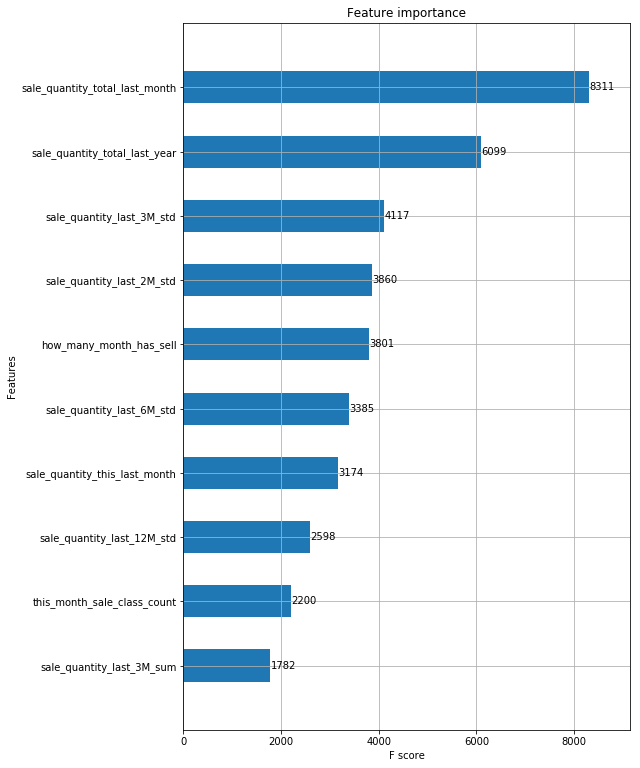

In [67]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=10, height=0.5, ax=ax)

## 利用全部训练集, 输出测试

In [9]:
rmses = []
trainset = xgb.DMatrix(train, label=labels)
testset = xgb.DMatrix(test)

params = {
'booster': 'gbtree', # 基于树的模型进行计算
'objective': 'reg:linear', # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 5, # 树的最大深度。缺省值为6
'lambda': 10, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=4000,evals=watchlist)
predict_test_X = model.predict(testset)

[0]	train-rmse:437.295
[1]	train-rmse:342.853
[2]	train-rmse:278.983
[3]	train-rmse:237.744
[4]	train-rmse:209.452
[5]	train-rmse:191.36
[6]	train-rmse:177.068
[7]	train-rmse:167.863
[8]	train-rmse:158.592
[9]	train-rmse:152.637
[10]	train-rmse:147.945
[11]	train-rmse:143.626
[12]	train-rmse:139.604
[13]	train-rmse:135.598
[14]	train-rmse:131.68
[15]	train-rmse:129.497
[16]	train-rmse:126.991
[17]	train-rmse:125.437
[18]	train-rmse:122.872
[19]	train-rmse:121.299
[20]	train-rmse:119.31
[21]	train-rmse:116.981
[22]	train-rmse:114.799
[23]	train-rmse:112.456
[24]	train-rmse:110.235
[25]	train-rmse:108.682
[26]	train-rmse:108.14
[27]	train-rmse:106.691
[28]	train-rmse:104.8
[29]	train-rmse:102.79
[30]	train-rmse:100.809
[31]	train-rmse:99.3651
[32]	train-rmse:98.3605
[33]	train-rmse:97.4717
[34]	train-rmse:96.6685
[35]	train-rmse:95.2323
[36]	train-rmse:94.7559
[37]	train-rmse:93.7207
[38]	train-rmse:93.0776
[39]	train-rmse:91.8692
[40]	train-rmse:90.8904
[41]	train-rmse:90.2791
[42]	trai

[334]	train-rmse:20.2003
[335]	train-rmse:20.1434
[336]	train-rmse:20.0201
[337]	train-rmse:19.9644
[338]	train-rmse:19.9302
[339]	train-rmse:19.8673
[340]	train-rmse:19.7817
[341]	train-rmse:19.7357
[342]	train-rmse:19.6765
[343]	train-rmse:19.6288
[344]	train-rmse:19.5126
[345]	train-rmse:19.4687
[346]	train-rmse:19.3763
[347]	train-rmse:19.2936
[348]	train-rmse:19.2403
[349]	train-rmse:19.2167
[350]	train-rmse:19.1262
[351]	train-rmse:19.0739
[352]	train-rmse:19.0212
[353]	train-rmse:18.9813
[354]	train-rmse:18.8962
[355]	train-rmse:18.8594
[356]	train-rmse:18.7977
[357]	train-rmse:18.7659
[358]	train-rmse:18.6967
[359]	train-rmse:18.6197
[360]	train-rmse:18.5622
[361]	train-rmse:18.4884
[362]	train-rmse:18.4122
[363]	train-rmse:18.3425
[364]	train-rmse:18.2711
[365]	train-rmse:18.1697
[366]	train-rmse:18.0976
[367]	train-rmse:18.0386
[368]	train-rmse:17.9785
[369]	train-rmse:17.8984
[370]	train-rmse:17.8236
[371]	train-rmse:17.7687
[372]	train-rmse:17.7015
[373]	train-rmse:17.6874


[664]	train-rmse:7.23001
[665]	train-rmse:7.21947
[666]	train-rmse:7.19747
[667]	train-rmse:7.18371
[668]	train-rmse:7.16769
[669]	train-rmse:7.14533
[670]	train-rmse:7.11526
[671]	train-rmse:7.08727
[672]	train-rmse:7.07426
[673]	train-rmse:7.04667
[674]	train-rmse:7.0199
[675]	train-rmse:6.99512
[676]	train-rmse:6.97827
[677]	train-rmse:6.9579
[678]	train-rmse:6.93443
[679]	train-rmse:6.91246
[680]	train-rmse:6.89814
[681]	train-rmse:6.88207
[682]	train-rmse:6.86549
[683]	train-rmse:6.84877
[684]	train-rmse:6.82907
[685]	train-rmse:6.80966
[686]	train-rmse:6.79276
[687]	train-rmse:6.77827
[688]	train-rmse:6.76391
[689]	train-rmse:6.75323
[690]	train-rmse:6.74116
[691]	train-rmse:6.7154
[692]	train-rmse:6.70187
[693]	train-rmse:6.69084
[694]	train-rmse:6.67249
[695]	train-rmse:6.65622
[696]	train-rmse:6.64315
[697]	train-rmse:6.62401
[698]	train-rmse:6.60643
[699]	train-rmse:6.59206
[700]	train-rmse:6.57898
[701]	train-rmse:6.55988
[702]	train-rmse:6.54714
[703]	train-rmse:6.53148
[70

[994]	train-rmse:3.24258
[995]	train-rmse:3.23975
[996]	train-rmse:3.22227
[997]	train-rmse:3.21803
[998]	train-rmse:3.20492
[999]	train-rmse:3.19498
[1000]	train-rmse:3.1901
[1001]	train-rmse:3.17476
[1002]	train-rmse:3.16843
[1003]	train-rmse:3.16271
[1004]	train-rmse:3.15636
[1005]	train-rmse:3.14922
[1006]	train-rmse:3.13989
[1007]	train-rmse:3.13255
[1008]	train-rmse:3.12602
[1009]	train-rmse:3.11912
[1010]	train-rmse:3.11392
[1011]	train-rmse:3.10794
[1012]	train-rmse:3.10568
[1013]	train-rmse:3.09935
[1014]	train-rmse:3.09029
[1015]	train-rmse:3.07986
[1016]	train-rmse:3.07406
[1017]	train-rmse:3.06549
[1018]	train-rmse:3.05557
[1019]	train-rmse:3.0505
[1020]	train-rmse:3.04481
[1021]	train-rmse:3.03856
[1022]	train-rmse:3.03054
[1023]	train-rmse:3.02707
[1024]	train-rmse:3.02051
[1025]	train-rmse:3.01662
[1026]	train-rmse:3.01363
[1027]	train-rmse:3.00974
[1028]	train-rmse:3.00543
[1029]	train-rmse:3.00156
[1030]	train-rmse:2.99865
[1031]	train-rmse:2.99485
[1032]	train-rmse:2.

[1311]	train-rmse:1.70324
[1312]	train-rmse:1.69964
[1313]	train-rmse:1.69698
[1314]	train-rmse:1.69398
[1315]	train-rmse:1.69277
[1316]	train-rmse:1.69024
[1317]	train-rmse:1.68732
[1318]	train-rmse:1.68528
[1319]	train-rmse:1.68312
[1320]	train-rmse:1.68178
[1321]	train-rmse:1.68038
[1322]	train-rmse:1.67784
[1323]	train-rmse:1.67377
[1324]	train-rmse:1.67318
[1325]	train-rmse:1.66686
[1326]	train-rmse:1.66515
[1327]	train-rmse:1.66125
[1328]	train-rmse:1.65874
[1329]	train-rmse:1.65607
[1330]	train-rmse:1.65196
[1331]	train-rmse:1.64944
[1332]	train-rmse:1.6446
[1333]	train-rmse:1.6415
[1334]	train-rmse:1.63584
[1335]	train-rmse:1.63154
[1336]	train-rmse:1.62872
[1337]	train-rmse:1.62634
[1338]	train-rmse:1.62452
[1339]	train-rmse:1.6183
[1340]	train-rmse:1.61523
[1341]	train-rmse:1.61272
[1342]	train-rmse:1.61047
[1343]	train-rmse:1.60771
[1344]	train-rmse:1.60467
[1345]	train-rmse:1.60212
[1346]	train-rmse:1.59909
[1347]	train-rmse:1.59612
[1348]	train-rmse:1.59382
[1349]	train-rm

[1628]	train-rmse:1.02766
[1629]	train-rmse:1.02685
[1630]	train-rmse:1.02582
[1631]	train-rmse:1.02445
[1632]	train-rmse:1.0218
[1633]	train-rmse:1.02035
[1634]	train-rmse:1.01916
[1635]	train-rmse:1.01741
[1636]	train-rmse:1.01665
[1637]	train-rmse:1.01561
[1638]	train-rmse:1.01344
[1639]	train-rmse:1.0125
[1640]	train-rmse:1.01165
[1641]	train-rmse:1.01012
[1642]	train-rmse:1.00879
[1643]	train-rmse:1.00741
[1644]	train-rmse:1.00643
[1645]	train-rmse:1.00466
[1646]	train-rmse:1.00289
[1647]	train-rmse:0.999643
[1648]	train-rmse:0.997903
[1649]	train-rmse:0.997424
[1650]	train-rmse:0.996883
[1651]	train-rmse:0.995709
[1652]	train-rmse:0.994208
[1653]	train-rmse:0.992808
[1654]	train-rmse:0.991727
[1655]	train-rmse:0.989717
[1656]	train-rmse:0.987579
[1657]	train-rmse:0.986303
[1658]	train-rmse:0.984832
[1659]	train-rmse:0.983791
[1660]	train-rmse:0.981674
[1661]	train-rmse:0.980754
[1662]	train-rmse:0.979788
[1663]	train-rmse:0.979328
[1664]	train-rmse:0.977809
[1665]	train-rmse:0.97

[1934]	train-rmse:0.680353
[1935]	train-rmse:0.679673
[1936]	train-rmse:0.679169
[1937]	train-rmse:0.678426
[1938]	train-rmse:0.677943
[1939]	train-rmse:0.677399
[1940]	train-rmse:0.676504
[1941]	train-rmse:0.675617
[1942]	train-rmse:0.674524
[1943]	train-rmse:0.673833
[1944]	train-rmse:0.673196
[1945]	train-rmse:0.672705
[1946]	train-rmse:0.671518
[1947]	train-rmse:0.67093
[1948]	train-rmse:0.670151
[1949]	train-rmse:0.669452
[1950]	train-rmse:0.669019
[1951]	train-rmse:0.667877
[1952]	train-rmse:0.667594
[1953]	train-rmse:0.666937
[1954]	train-rmse:0.666264
[1955]	train-rmse:0.665843
[1956]	train-rmse:0.664994
[1957]	train-rmse:0.664292
[1958]	train-rmse:0.663244
[1959]	train-rmse:0.662698
[1960]	train-rmse:0.662151
[1961]	train-rmse:0.661317
[1962]	train-rmse:0.660519
[1963]	train-rmse:0.658679
[1964]	train-rmse:0.657813
[1965]	train-rmse:0.656918
[1966]	train-rmse:0.656241
[1967]	train-rmse:0.655706
[1968]	train-rmse:0.655026
[1969]	train-rmse:0.654231
[1970]	train-rmse:0.653689
[1

[2239]	train-rmse:0.488301
[2240]	train-rmse:0.487828
[2241]	train-rmse:0.487421
[2242]	train-rmse:0.486451
[2243]	train-rmse:0.486041
[2244]	train-rmse:0.485605
[2245]	train-rmse:0.48492
[2246]	train-rmse:0.484555
[2247]	train-rmse:0.483695
[2248]	train-rmse:0.483534
[2249]	train-rmse:0.482925
[2250]	train-rmse:0.48245
[2251]	train-rmse:0.481735
[2252]	train-rmse:0.480928
[2253]	train-rmse:0.480379
[2254]	train-rmse:0.479706
[2255]	train-rmse:0.479256
[2256]	train-rmse:0.47856
[2257]	train-rmse:0.477632
[2258]	train-rmse:0.477233
[2259]	train-rmse:0.476871
[2260]	train-rmse:0.476709
[2261]	train-rmse:0.476438
[2262]	train-rmse:0.475522
[2263]	train-rmse:0.474942
[2264]	train-rmse:0.47426
[2265]	train-rmse:0.473699
[2266]	train-rmse:0.473326
[2267]	train-rmse:0.472892
[2268]	train-rmse:0.472486
[2269]	train-rmse:0.471928
[2270]	train-rmse:0.47138
[2271]	train-rmse:0.471071
[2272]	train-rmse:0.470795
[2273]	train-rmse:0.47013
[2274]	train-rmse:0.46964
[2275]	train-rmse:0.469128
[2276]	t

[2544]	train-rmse:0.362247
[2545]	train-rmse:0.361897
[2546]	train-rmse:0.361643
[2547]	train-rmse:0.361268
[2548]	train-rmse:0.360883
[2549]	train-rmse:0.360657
[2550]	train-rmse:0.360344
[2551]	train-rmse:0.359946
[2552]	train-rmse:0.359727
[2553]	train-rmse:0.359477
[2554]	train-rmse:0.359031
[2555]	train-rmse:0.35881
[2556]	train-rmse:0.358691
[2557]	train-rmse:0.358456
[2558]	train-rmse:0.358117
[2559]	train-rmse:0.357803
[2560]	train-rmse:0.357332
[2561]	train-rmse:0.356848
[2562]	train-rmse:0.35663
[2563]	train-rmse:0.356428
[2564]	train-rmse:0.356125
[2565]	train-rmse:0.355978
[2566]	train-rmse:0.355479
[2567]	train-rmse:0.355194
[2568]	train-rmse:0.354921
[2569]	train-rmse:0.354691
[2570]	train-rmse:0.354617
[2571]	train-rmse:0.354479
[2572]	train-rmse:0.353824
[2573]	train-rmse:0.353641
[2574]	train-rmse:0.353433
[2575]	train-rmse:0.353206
[2576]	train-rmse:0.352832
[2577]	train-rmse:0.352553
[2578]	train-rmse:0.352399
[2579]	train-rmse:0.352074
[2580]	train-rmse:0.351556
[25

[2849]	train-rmse:0.283505
[2850]	train-rmse:0.283286
[2851]	train-rmse:0.2832
[2852]	train-rmse:0.282977
[2853]	train-rmse:0.282739
[2854]	train-rmse:0.28266
[2855]	train-rmse:0.282358
[2856]	train-rmse:0.282224
[2857]	train-rmse:0.282047
[2858]	train-rmse:0.281923
[2859]	train-rmse:0.281699
[2860]	train-rmse:0.281505
[2861]	train-rmse:0.281282
[2862]	train-rmse:0.281181
[2863]	train-rmse:0.281101
[2864]	train-rmse:0.280813
[2865]	train-rmse:0.280555
[2866]	train-rmse:0.280276
[2867]	train-rmse:0.279948
[2868]	train-rmse:0.279687
[2869]	train-rmse:0.279402
[2870]	train-rmse:0.279253
[2871]	train-rmse:0.278984
[2872]	train-rmse:0.278922
[2873]	train-rmse:0.27871
[2874]	train-rmse:0.278616
[2875]	train-rmse:0.278335
[2876]	train-rmse:0.278198
[2877]	train-rmse:0.278036
[2878]	train-rmse:0.277931
[2879]	train-rmse:0.277744
[2880]	train-rmse:0.277657
[2881]	train-rmse:0.27758
[2882]	train-rmse:0.277482
[2883]	train-rmse:0.277183
[2884]	train-rmse:0.276997
[2885]	train-rmse:0.276808
[2886]

[3155]	train-rmse:0.23738
[3156]	train-rmse:0.237343
[3157]	train-rmse:0.237141
[3158]	train-rmse:0.237031
[3159]	train-rmse:0.236946
[3160]	train-rmse:0.236858
[3161]	train-rmse:0.236635
[3162]	train-rmse:0.236467
[3163]	train-rmse:0.236428
[3164]	train-rmse:0.236292
[3165]	train-rmse:0.236103
[3166]	train-rmse:0.235979
[3167]	train-rmse:0.23587
[3168]	train-rmse:0.23573
[3169]	train-rmse:0.235582
[3170]	train-rmse:0.235467
[3171]	train-rmse:0.23541
[3172]	train-rmse:0.235324
[3173]	train-rmse:0.235209
[3174]	train-rmse:0.235147
[3175]	train-rmse:0.234923
[3176]	train-rmse:0.234838
[3177]	train-rmse:0.234788
[3178]	train-rmse:0.234715
[3179]	train-rmse:0.234612
[3180]	train-rmse:0.234492
[3181]	train-rmse:0.2344
[3182]	train-rmse:0.234262
[3183]	train-rmse:0.23423
[3184]	train-rmse:0.234129
[3185]	train-rmse:0.233931
[3186]	train-rmse:0.233922
[3187]	train-rmse:0.233748
[3188]	train-rmse:0.233527
[3189]	train-rmse:0.233511
[3190]	train-rmse:0.233374
[3191]	train-rmse:0.233346
[3192]	t

[3460]	train-rmse:0.208936
[3461]	train-rmse:0.208851
[3462]	train-rmse:0.208797
[3463]	train-rmse:0.208756
[3464]	train-rmse:0.208641
[3465]	train-rmse:0.208622
[3466]	train-rmse:0.208622
[3467]	train-rmse:0.208589
[3468]	train-rmse:0.208487
[3469]	train-rmse:0.208438
[3470]	train-rmse:0.20842
[3471]	train-rmse:0.208359
[3472]	train-rmse:0.208292
[3473]	train-rmse:0.20819
[3474]	train-rmse:0.208136
[3475]	train-rmse:0.208068
[3476]	train-rmse:0.208068
[3477]	train-rmse:0.208018
[3478]	train-rmse:0.207923
[3479]	train-rmse:0.207815
[3480]	train-rmse:0.207766
[3481]	train-rmse:0.207727
[3482]	train-rmse:0.207501
[3483]	train-rmse:0.207356
[3484]	train-rmse:0.207233
[3485]	train-rmse:0.207166
[3486]	train-rmse:0.207078
[3487]	train-rmse:0.207082
[3488]	train-rmse:0.207006
[3489]	train-rmse:0.206981
[3490]	train-rmse:0.206875
[3491]	train-rmse:0.20686
[3492]	train-rmse:0.206813
[3493]	train-rmse:0.206783
[3494]	train-rmse:0.206763
[3495]	train-rmse:0.206723
[3496]	train-rmse:0.206654
[349

[3765]	train-rmse:0.190489
[3766]	train-rmse:0.190474
[3767]	train-rmse:0.190447
[3768]	train-rmse:0.190444
[3769]	train-rmse:0.190382
[3770]	train-rmse:0.19036
[3771]	train-rmse:0.190265
[3772]	train-rmse:0.190251
[3773]	train-rmse:0.19021
[3774]	train-rmse:0.190108
[3775]	train-rmse:0.189995
[3776]	train-rmse:0.189995
[3777]	train-rmse:0.18997
[3778]	train-rmse:0.189961
[3779]	train-rmse:0.189908
[3780]	train-rmse:0.189871
[3781]	train-rmse:0.189849
[3782]	train-rmse:0.18981
[3783]	train-rmse:0.189806
[3784]	train-rmse:0.189776
[3785]	train-rmse:0.189707
[3786]	train-rmse:0.189657
[3787]	train-rmse:0.189656
[3788]	train-rmse:0.18966
[3789]	train-rmse:0.189648
[3790]	train-rmse:0.189648
[3791]	train-rmse:0.189607
[3792]	train-rmse:0.18956
[3793]	train-rmse:0.18956
[3794]	train-rmse:0.189511
[3795]	train-rmse:0.189463
[3796]	train-rmse:0.189413
[3797]	train-rmse:0.189417
[3798]	train-rmse:0.18938
[3799]	train-rmse:0.189272
[3800]	train-rmse:0.189282
[3801]	train-rmse:0.189276
[3802]	tr

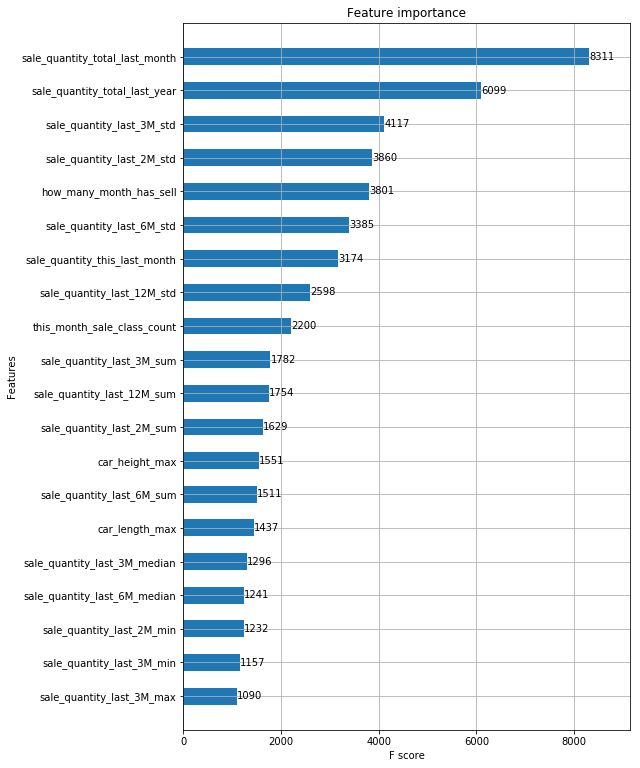

In [13]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

In [14]:
submit['predict_quantity'] = predict_test_X
submit.to_csv('../../raw/LiChuan/result_20180208_xgboost-allfeatures.csv',index=False, header=True)  

## allfeatures + baseline *1.1

In [20]:
baseline = pd.read_csv('../../raw/Submissions/result_201710.csv')
submit['predict_quantity'] = baseline['predict_quantity'] * 1.1 * 0.5 + predict_test_X * 0.5

In [21]:
submit.to_csv('../../raw/LiChuan/result_20180208_xgboost-allfeatures*0.5-baseline*0.5*1.1.csv',index=False, header=True) 